# Decoder-only transformer with convolutional embedding experiments

This notebook contains experiments of decoder-only transformer with convolutional embedding applied in the context of timeseries forecasting. In this notebook, you will find the following experiments:
- **Experiment 1**: 1-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 2**: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 3**: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target
- **Experiment 4**: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series
- **Experiment 5**: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target
- **Experiment 6**: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target
- **Experiment 7**: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import ConvolutionalDecoderOnlyTransformer
from src.Transformer.TransformerModules import DotProductAttention
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

In [2]:
# configs
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif  torch.cuda.is_available():    
    device = 'cuda'
else:
    device = 'cpu'
    
x = torch.ones(1, device=device)
print(x)

# attention module
_attention = DotProductAttention()

# meta data to store images
FOLDER = "conv_embedding"

# transformer configs
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = emb_size // n_heads          # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 1000                            # training epochs

tensor([1.], device='mps:0')


## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [3]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [5]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [6]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
 
model = early_stopper.best_model           

epoch=0	train_loss=2386.5049	val_loss=1553.0893	train_mape_loss=2.5447	val_mape_loss=2.5417	R_p=['0.3269', '0.4141']
epoch=1	train_loss=1406.6296	val_loss=892.6968	train_mape_loss=2.6616	val_mape_loss=1.2639	R_p=['0.2439', '0.2359']
epoch=2	train_loss=539.4252	val_loss=247.3147	train_mape_loss=0.9429	val_mape_loss=0.4675	R_p=['0.1403', '0.2003']
epoch=3	train_loss=277.1310	val_loss=228.9419	train_mape_loss=0.6577	val_mape_loss=0.4396	R_p=['0.1443', '0.2371']
epoch=4	train_loss=187.0236	val_loss=230.1553	train_mape_loss=0.5270	val_mape_loss=0.3415	R_p=['0.1521', '0.2500']
epoch=5	train_loss=168.1242	val_loss=201.7892	train_mape_loss=0.4840	val_mape_loss=0.4129	R_p=['0.1400', '0.2343']
epoch=6	train_loss=157.1934	val_loss=155.5475	train_mape_loss=0.4680	val_mape_loss=0.3131	R_p=['0.1117', '0.1790']
epoch=7	train_loss=145.1868	val_loss=163.2585	train_mape_loss=0.4452	val_mape_loss=0.3138	R_p=['0.1238', '0.2036']
epoch=8	train_loss=134.6790	val_loss=176.0941	train_mape_loss=0.4326	val_mape

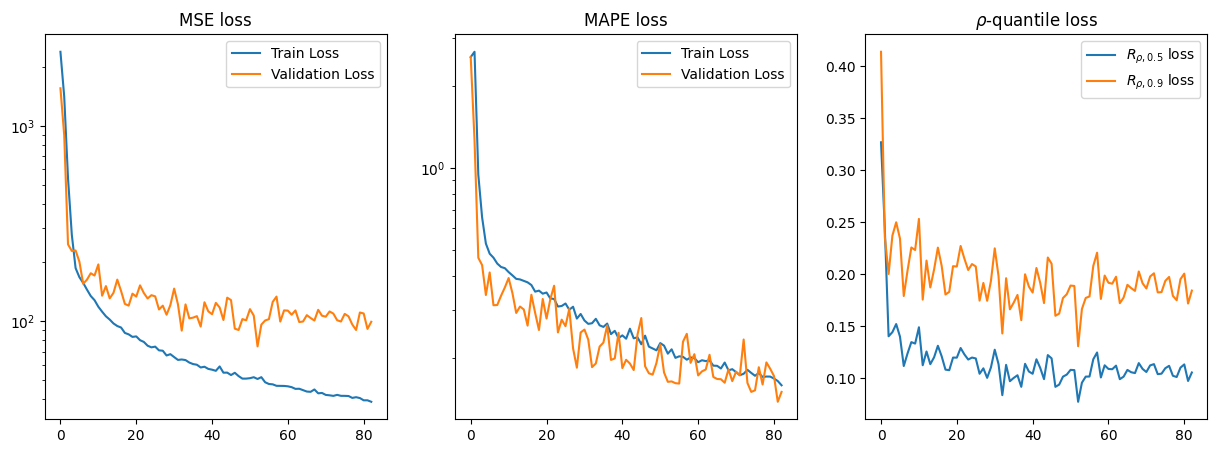

In [7]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [8]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(76.9620415649414,
 0.16979056692123412,
 [0.07813966274261475, 0.1327165812253952])

### Predict

In [9]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

In [10]:
inspect_step = 0

In [11]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

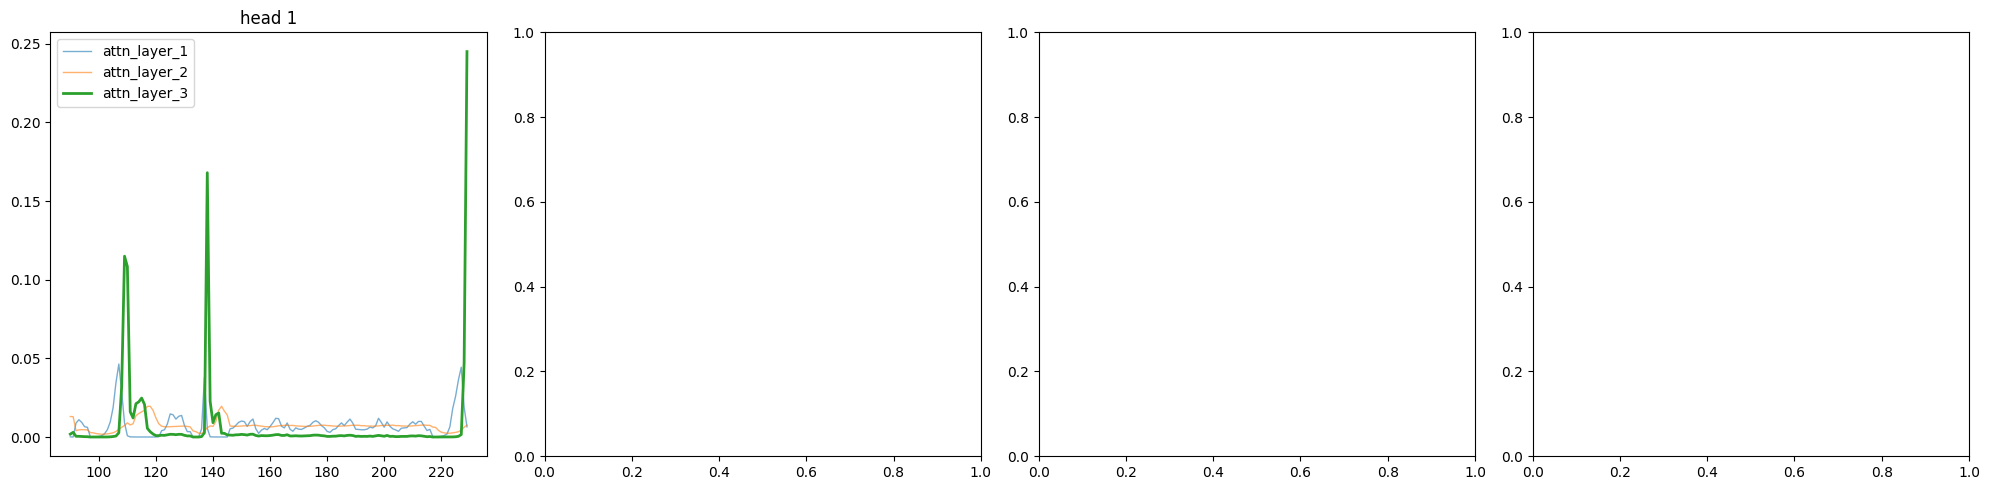

In [12]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

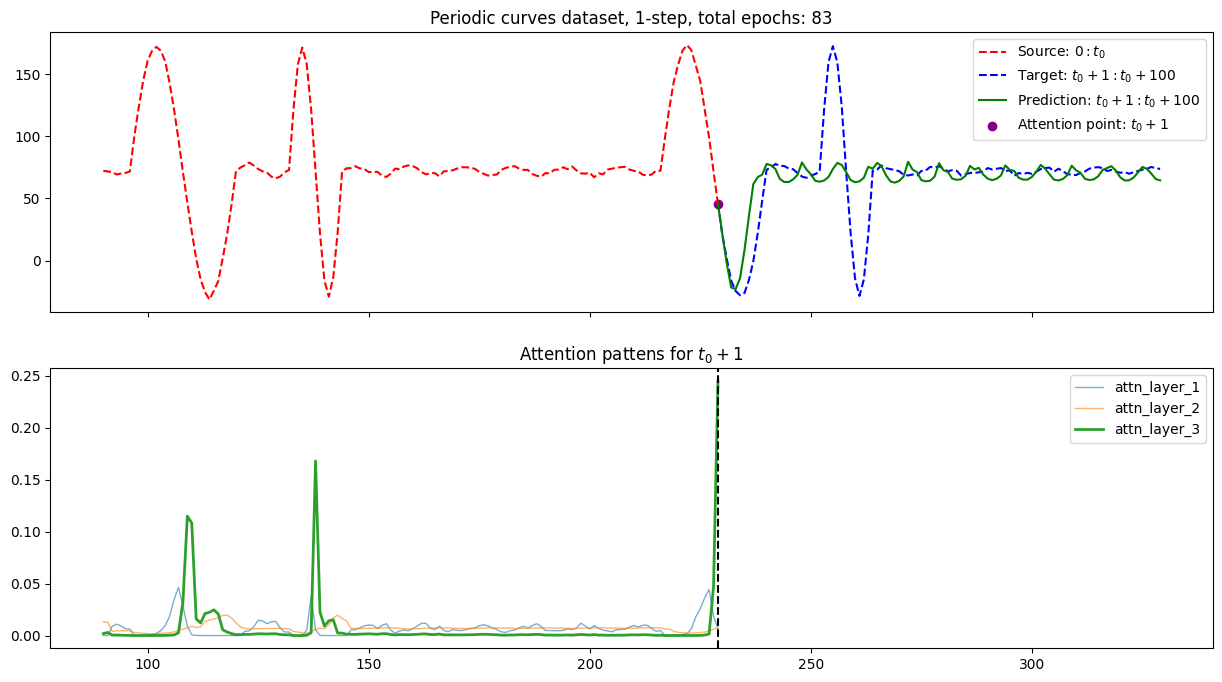

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [14]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

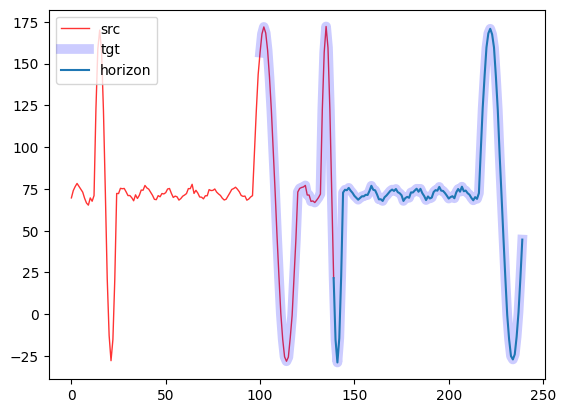

In [15]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [16]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [17]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
 
model = early_stopper.best_model           

epoch=0	train_loss=2443.6100	val_loss=1564.6145	train_mape_loss=2.4084	val_mape_loss=2.7166	R_p=['0.3294', '0.4145']
epoch=1	train_loss=1507.0409	val_loss=1584.0192	train_mape_loss=2.8409	val_mape_loss=2.6814	R_p=['0.3408', '0.4386']
epoch=2	train_loss=1502.5120	val_loss=1544.2415	train_mape_loss=2.8287	val_mape_loss=2.6855	R_p=['0.3229', '0.4031']
epoch=3	train_loss=1456.1738	val_loss=1431.5148	train_mape_loss=2.6481	val_mape_loss=2.3448	R_p=['0.3078', '0.3913']
epoch=4	train_loss=1372.3785	val_loss=1403.2811	train_mape_loss=2.3354	val_mape_loss=2.0346	R_p=['0.3077', '0.4142']
epoch=5	train_loss=1286.8642	val_loss=1218.8917	train_mape_loss=2.1668	val_mape_loss=2.4026	R_p=['0.2928', '0.3348']
epoch=6	train_loss=1159.2701	val_loss=1104.5467	train_mape_loss=2.2176	val_mape_loss=2.3260	R_p=['0.2653', '0.3310']
epoch=7	train_loss=1037.8256	val_loss=977.2926	train_mape_loss=2.1453	val_mape_loss=2.4164	R_p=['0.2667', '0.3067']
epoch=8	train_loss=943.4999	val_loss=942.3528	train_mape_loss=2.0

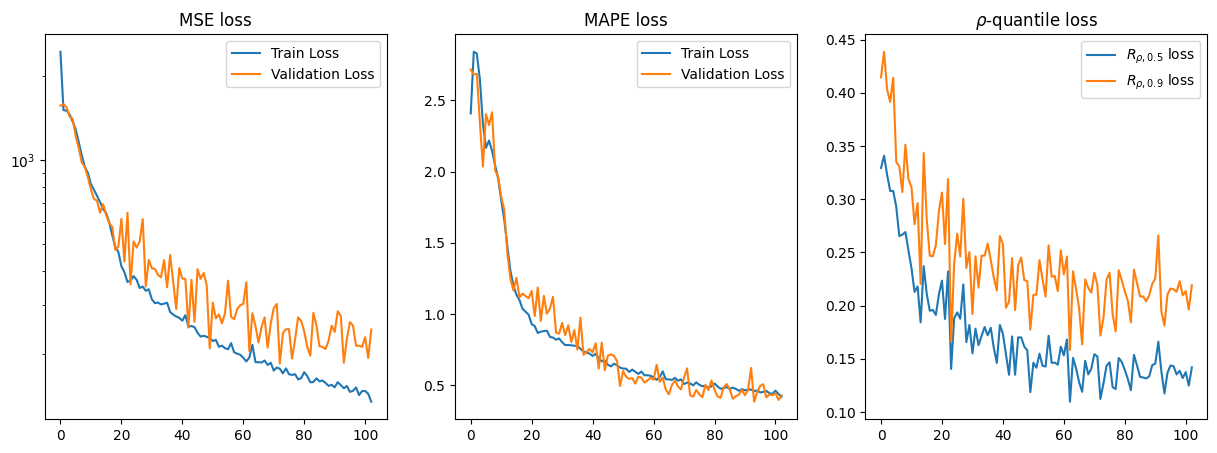

In [18]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [19]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(185.3419376220703,
 0.37155435514450075,
 [0.11263807862997055, 0.17188796401023865])

### Predict

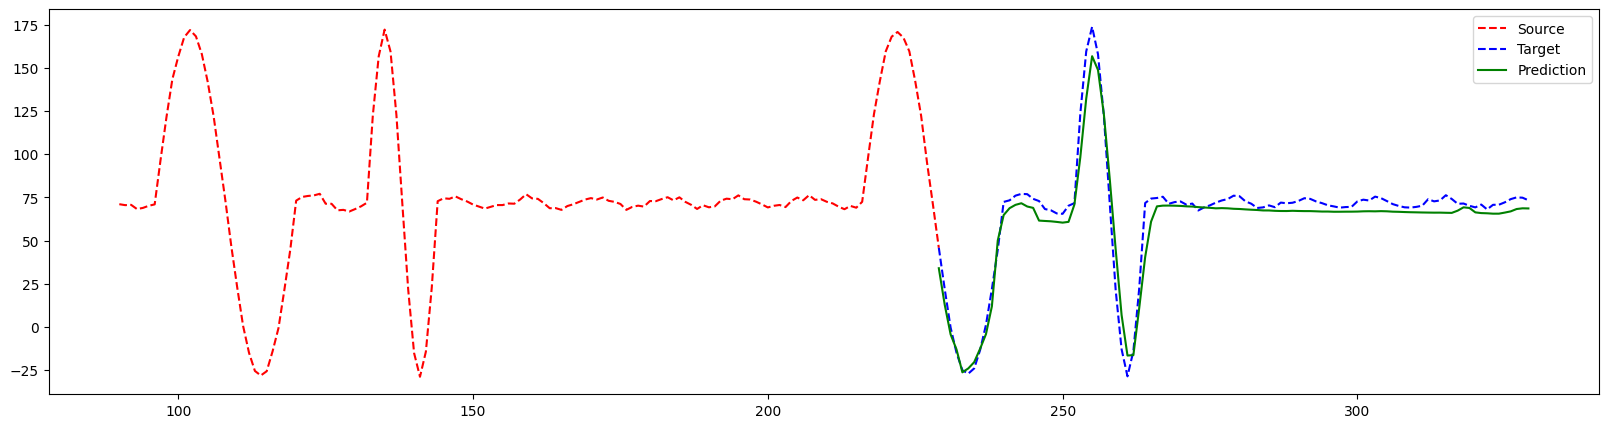

In [20]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [21]:
inspect_step = 0

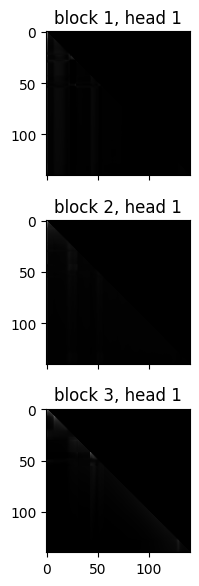

In [22]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

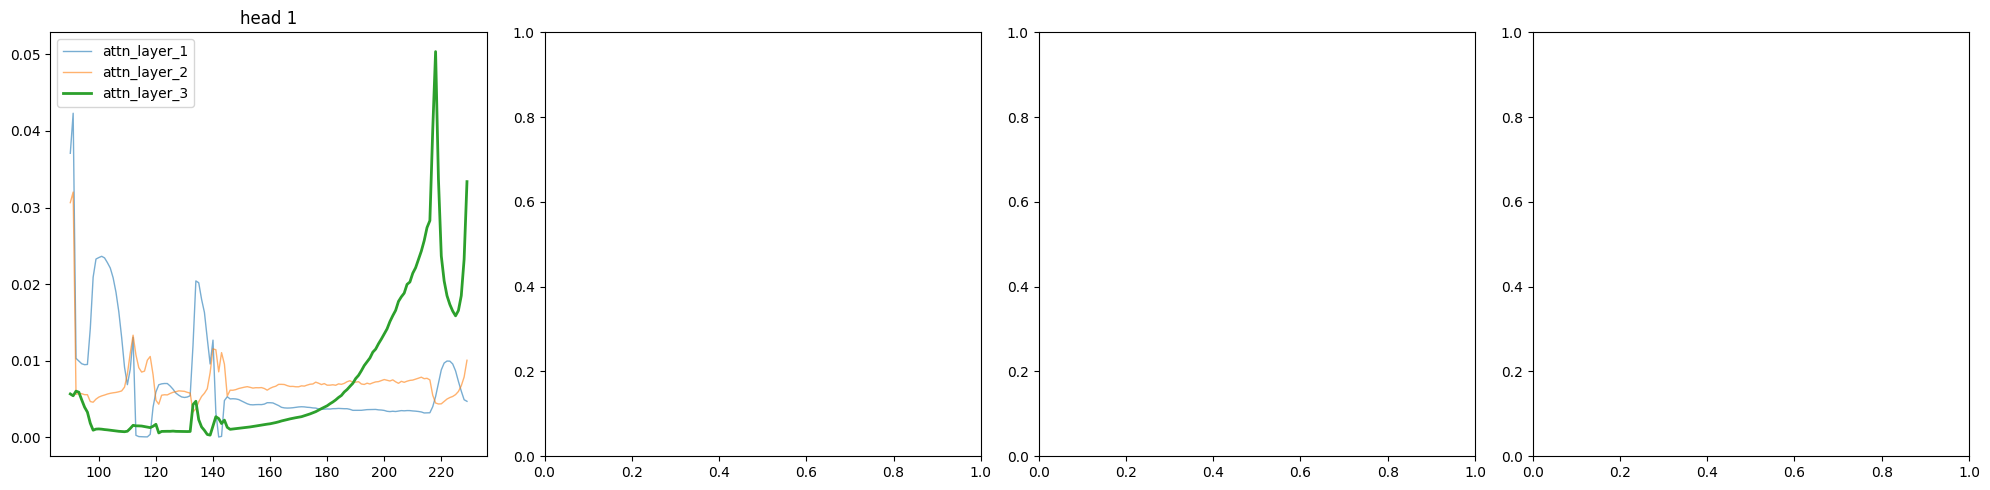

In [23]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

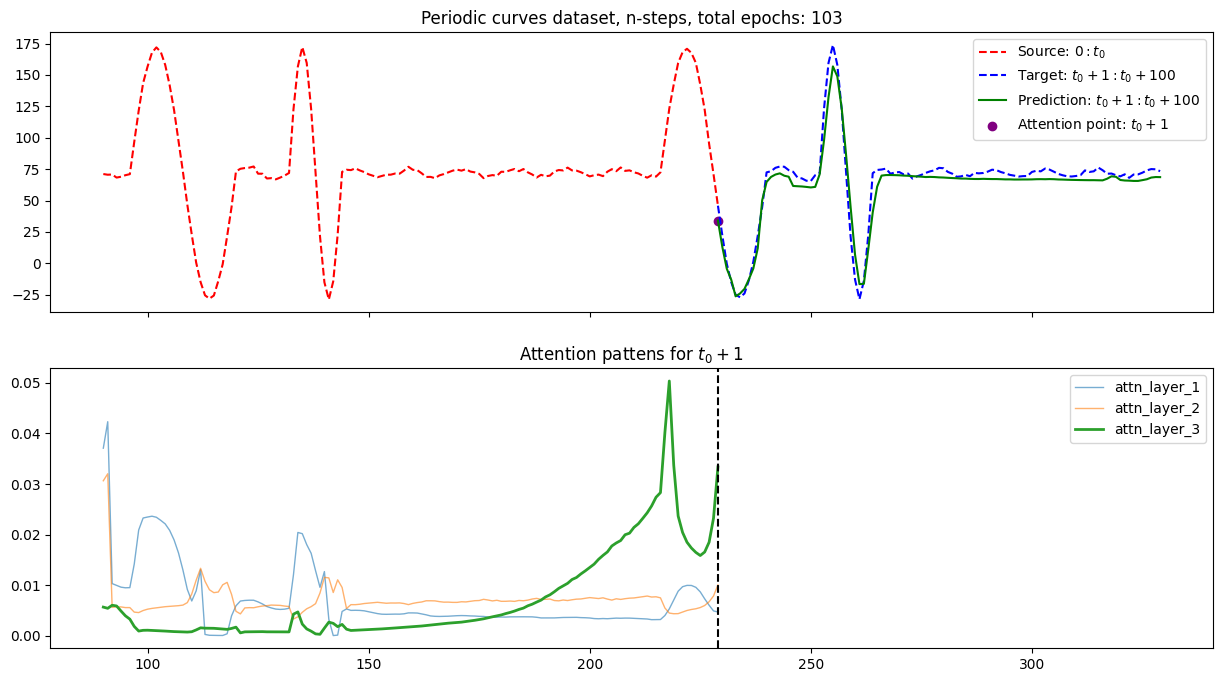

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
    ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")

ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target

In [25]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

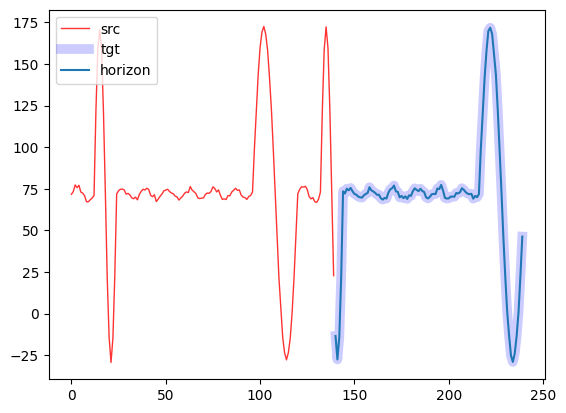

In [26]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [27]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [28]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift,
                                                      device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(
        f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
  
model = early_stopper.best_model          

epoch=0	train_loss=2423.2107	val_loss=1576.8994	train_mape_loss=4.2249	val_mape_loss=4.9161	R_p=['0.3332', '0.4188']
epoch=1	train_loss=1505.4488	val_loss=1566.5622	train_mape_loss=5.0959	val_mape_loss=4.9552	R_p=['0.3273', '0.4066']
epoch=2	train_loss=1455.8883	val_loss=1286.4591	train_mape_loss=4.9152	val_mape_loss=4.1695	R_p=['0.2836', '0.3606']
epoch=3	train_loss=1191.2747	val_loss=1236.9356	train_mape_loss=4.2137	val_mape_loss=4.3759	R_p=['0.2887', '0.3731']
epoch=4	train_loss=1108.5488	val_loss=1203.0105	train_mape_loss=4.2046	val_mape_loss=4.7508	R_p=['0.2936', '0.3629']
epoch=5	train_loss=1057.4447	val_loss=1077.9751	train_mape_loss=4.1804	val_mape_loss=3.7464	R_p=['0.2738', '0.3686']
epoch=6	train_loss=978.5123	val_loss=1002.4842	train_mape_loss=4.0753	val_mape_loss=3.7550	R_p=['0.2805', '0.3919']
epoch=7	train_loss=874.3857	val_loss=818.6962	train_mape_loss=3.8562	val_mape_loss=3.8055	R_p=['0.2448', '0.3164']
epoch=8	train_loss=787.5347	val_loss=824.1261	train_mape_loss=3.592

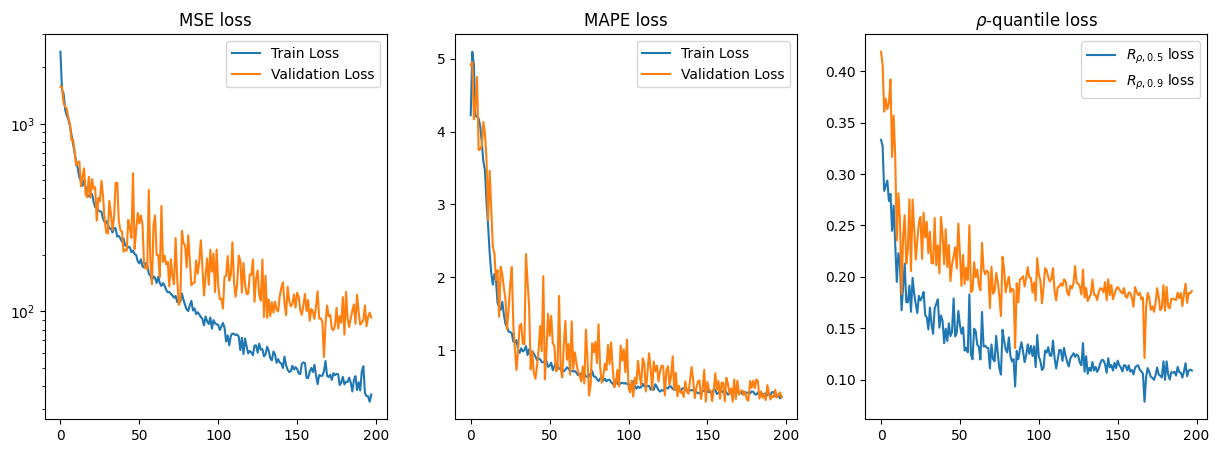

In [29]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [30]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(58.06040045166016,
 0.5325121874809265,
 [0.07936552166938782, 0.12214845418930054])

### Predict

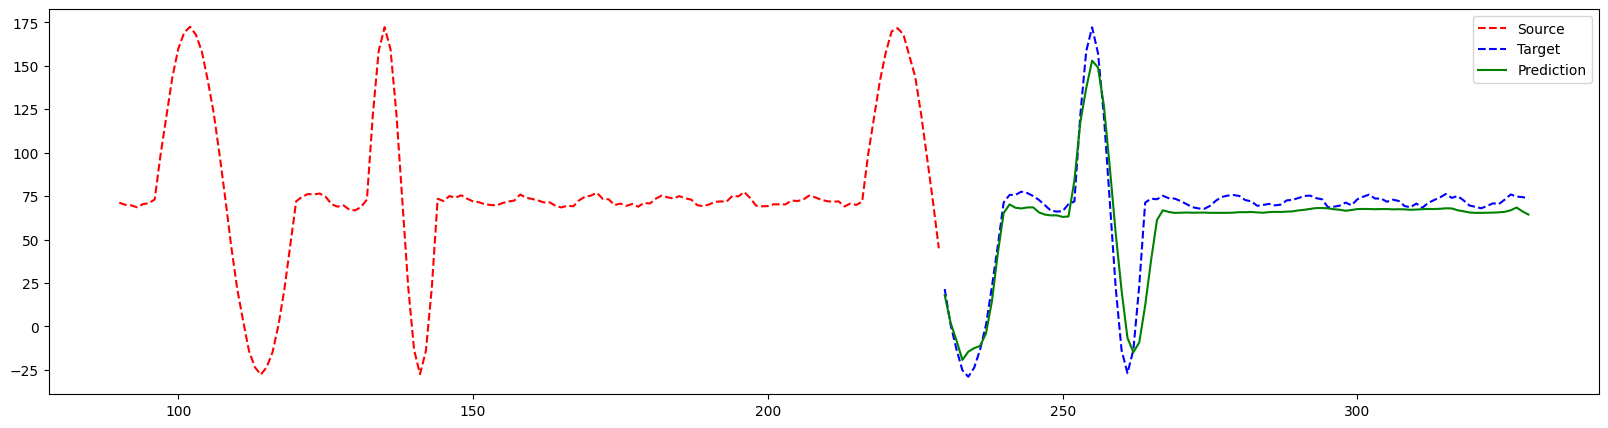

In [31]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [32]:
inspect_step = 0

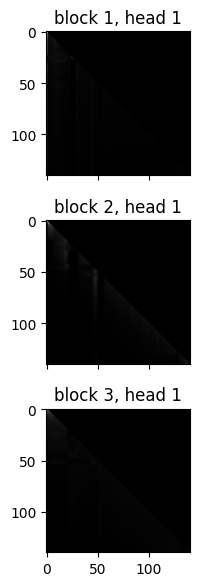

In [33]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

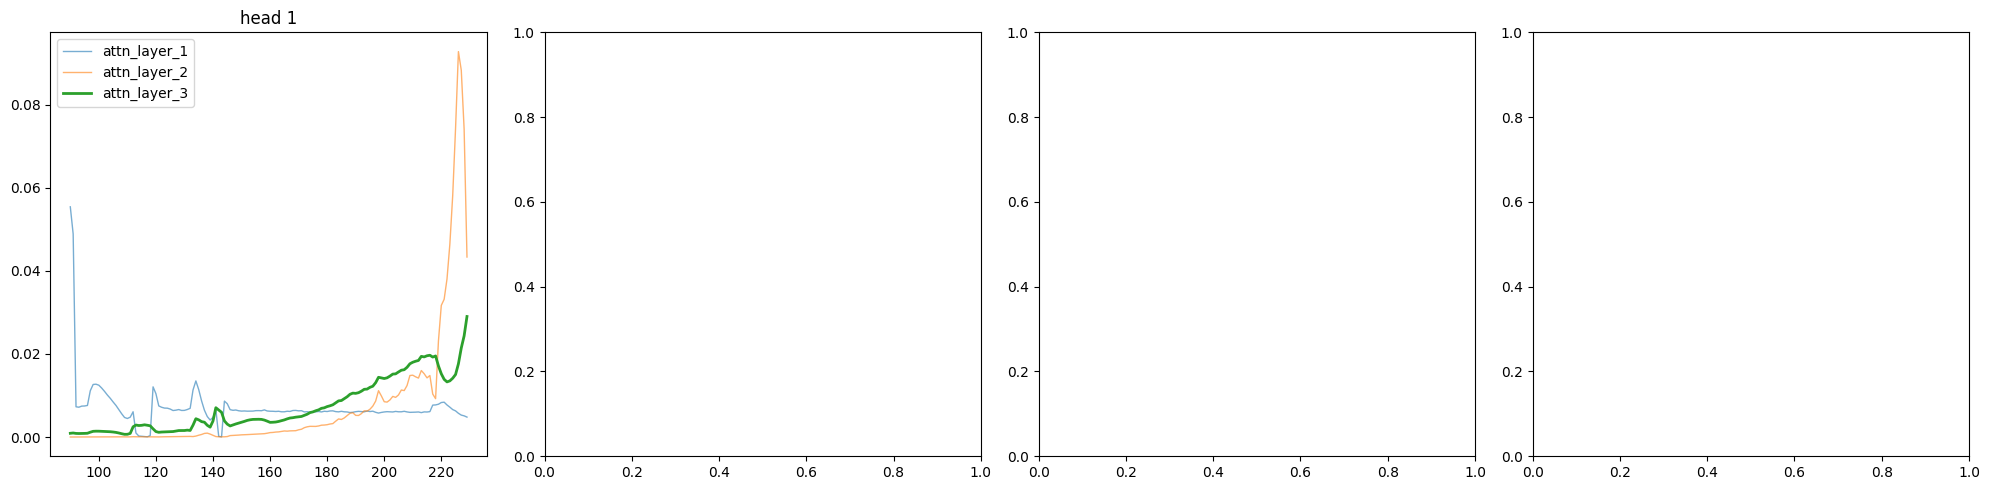

In [34]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

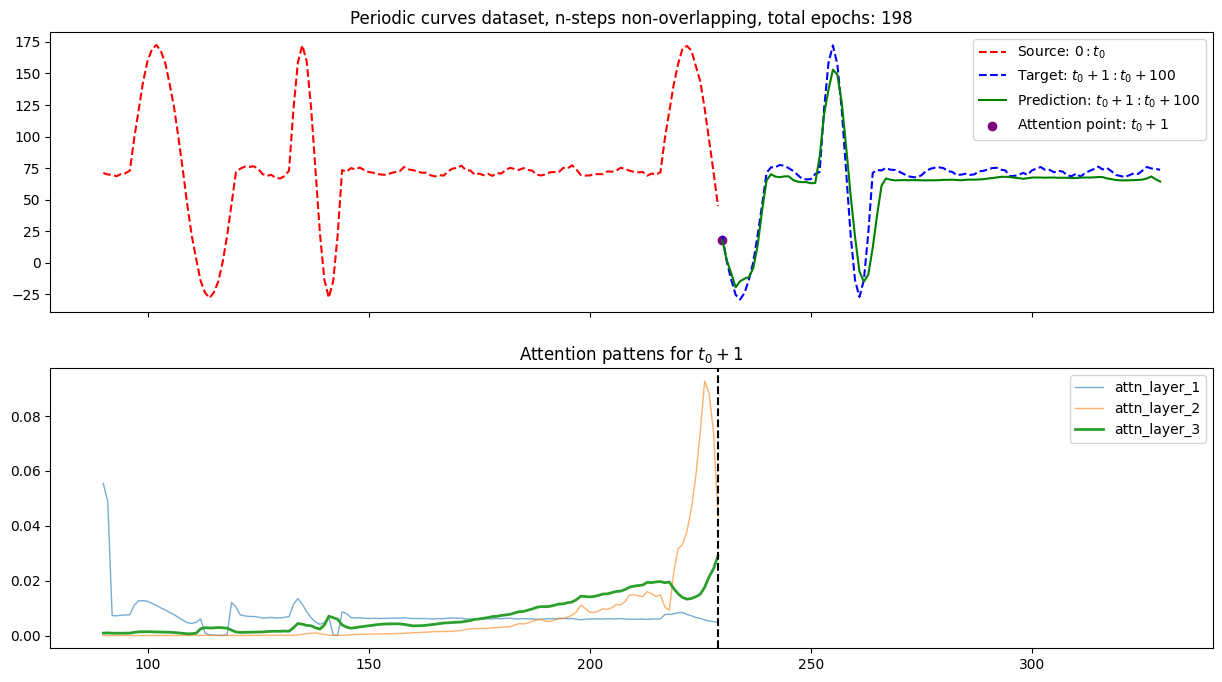

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 4: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series

In [36]:
DATASET_NAME = "multivar_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 100                      # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultivarPeriodicDataset(len_timeseries=total_length, n_timeseries=n_timeseries, seq_len=seq_len, shift=shift, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

In [37]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

ith = 0 # i-th time series

plt.plot(src_X, src_fX[:, ith], 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX[:, ith], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, ith], tgt_fX[-shift-1:, ith], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

(torch.Size([140, 1]),
 torch.Size([140, 100]),
 torch.Size([100, 1]),
 torch.Size([100, 100]))

### Training setup

In [38]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [39]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
  
model = early_stopper.best_model          

epoch=0	train_loss=2222.9273	val_loss=737.5426	train_mape_loss=0.5782	val_mape_loss=0.3791	R_p=['0.3038', '0.3984']
epoch=1	train_loss=639.5288	val_loss=506.4247	train_mape_loss=0.3903	val_mape_loss=0.2990	R_p=['0.2513', '0.3704']
epoch=2	train_loss=261.8747	val_loss=234.6440	train_mape_loss=0.2461	val_mape_loss=0.1833	R_p=['0.1666', '0.2700']
epoch=3	train_loss=119.9404	val_loss=192.1267	train_mape_loss=0.1552	val_mape_loss=0.1728	R_p=['0.1585', '0.2672']
epoch=4	train_loss=99.0383	val_loss=201.7714	train_mape_loss=0.1376	val_mape_loss=0.1803	R_p=['0.1647', '0.2839']
epoch=5	train_loss=90.1383	val_loss=184.8636	train_mape_loss=0.1293	val_mape_loss=0.1706	R_p=['0.1586', '0.2724']
epoch=6	train_loss=78.6039	val_loss=151.3764	train_mape_loss=0.1168	val_mape_loss=0.1532	R_p=['0.1436', '0.2458']
epoch=7	train_loss=57.9025	val_loss=115.4829	train_mape_loss=0.0936	val_mape_loss=0.1352	R_p=['0.1287', '0.2235']
epoch=8	train_loss=38.5252	val_loss=97.2032	train_mape_loss=0.0732	val_mape_loss=0.

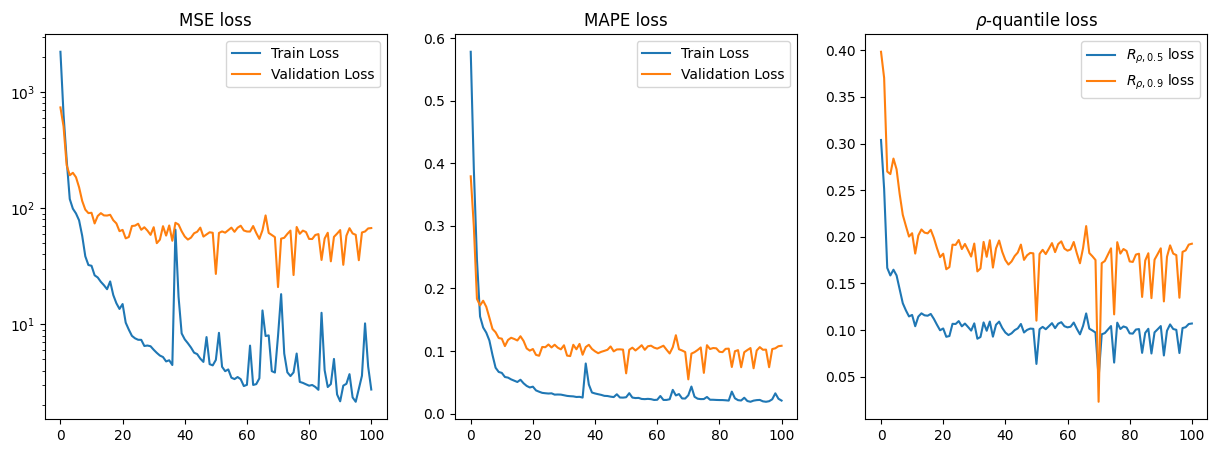

In [40]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [41]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(20.63904313659668,
 0.05456339403986931,
 [0.0486927330493927, 0.023134058341383934])

### Predict

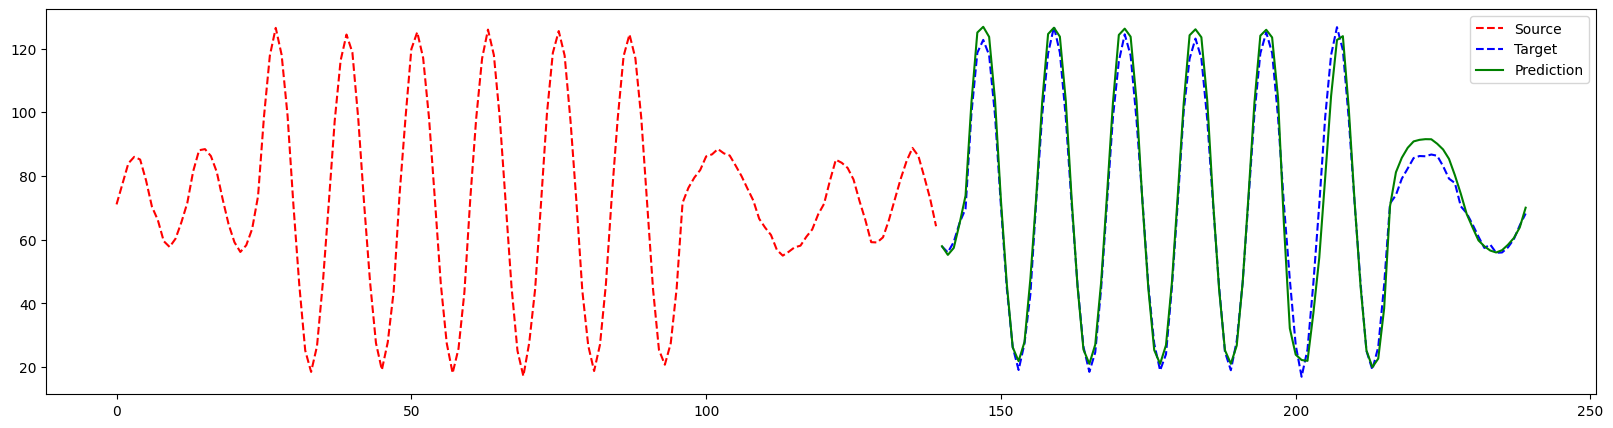

In [42]:
idx = 0 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

ith = 3

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source")
plt.plot(tgt_X, tgt_fX[:, ith], '--b', label="Target")
plt.plot(tgt_X, pred_fX[:, ith], '-g', label="Prediction")
plt.legend()

In [43]:
inspect_step = 0

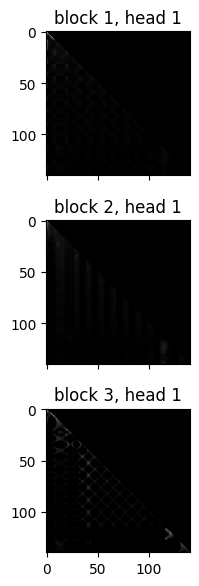

In [44]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

In [45]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Multivariate Periodic curves dataset, n-steps non-overlapping, {ith}-th time series, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 5: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target

### Step function

In [47]:
DATASET_NAME = "step"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.StepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

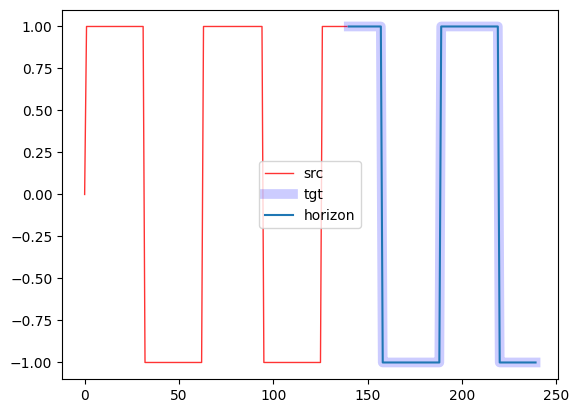

In [48]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [49]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden*2,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [50]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
         
model = early_stopper.best_model   

epoch=0	train_loss=1.0416	val_loss=1.0015	train_mape_loss=1.0020	val_mape_loss=0.9992	R_p=['0.9992', '1.0333']
epoch=1	train_loss=1.0028	val_loss=1.0024	train_mape_loss=0.9998	val_mape_loss=1.0004	R_p=['1.0004', '0.9589']
epoch=2	train_loss=1.0019	val_loss=1.0073	train_mape_loss=0.9998	val_mape_loss=0.9986	R_p=['0.9986', '1.0688']
epoch=3	train_loss=1.0020	val_loss=1.0004	train_mape_loss=1.0001	val_mape_loss=0.9993	R_p=['0.9993', '1.0221']
epoch=4	train_loss=1.0039	val_loss=1.0059	train_mape_loss=1.0000	val_mape_loss=1.0007	R_p=['1.0007', '0.9369']
epoch=5	train_loss=1.0014	val_loss=0.9998	train_mape_loss=0.9998	val_mape_loss=0.9993	R_p=['0.9993', '1.0154']
epoch=6	train_loss=1.0007	val_loss=1.0005	train_mape_loss=0.9995	val_mape_loss=0.9988	R_p=['0.9988', '1.0319']
epoch=7	train_loss=1.0015	val_loss=0.9975	train_mape_loss=0.9992	val_mape_loss=0.9987	R_p=['0.9987', '0.9851']
epoch=8	train_loss=0.9762	val_loss=0.6887	train_mape_loss=0.9768	val_mape_loss=0.7611	R_p=['0.7611', '0.7434']
e

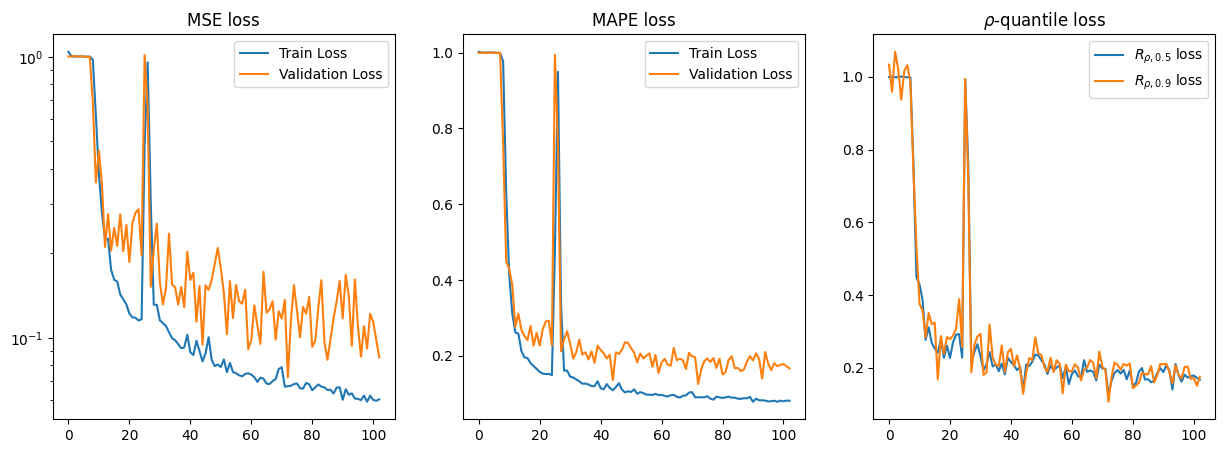

In [51]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [52]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.08024101477861405,
 0.13037880623340606,
 [0.1303788125514984, 0.10786723345518112])

#### Predict

In [53]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [54]:
inspect_step = 0

In [55]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

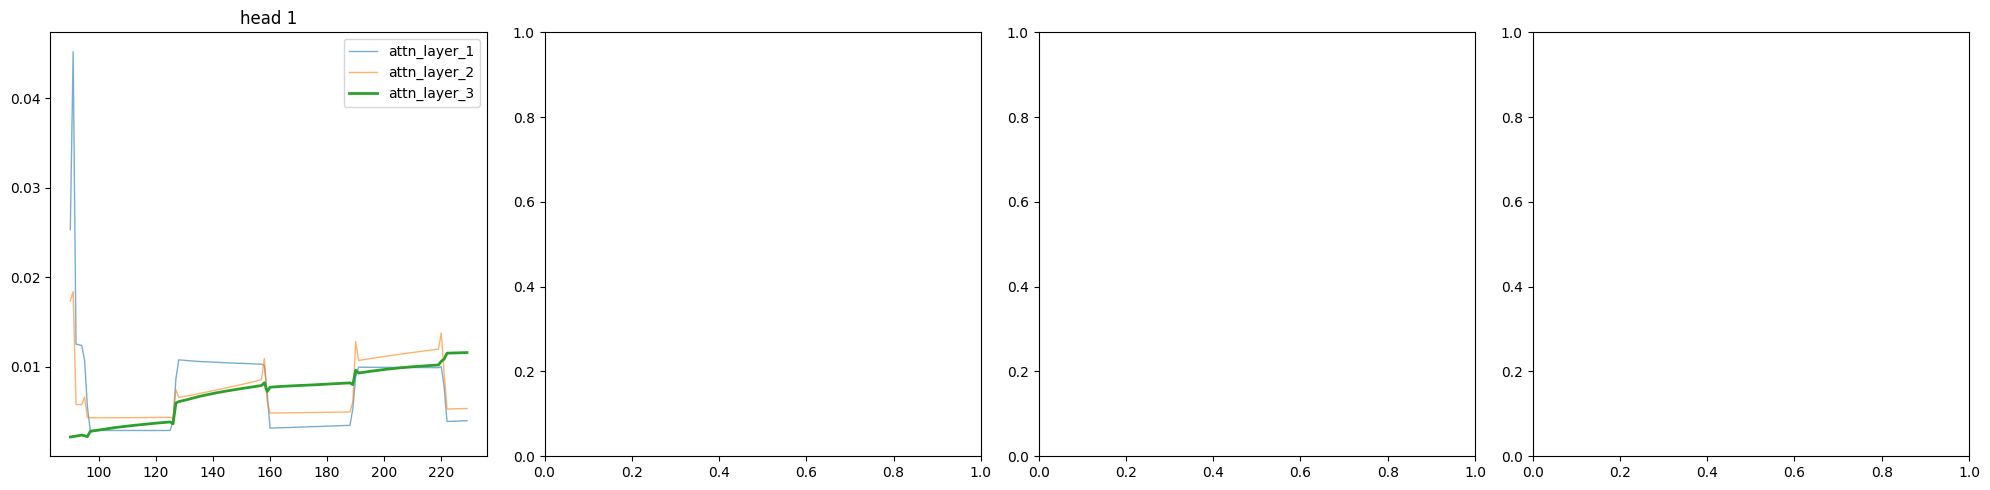

In [56]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

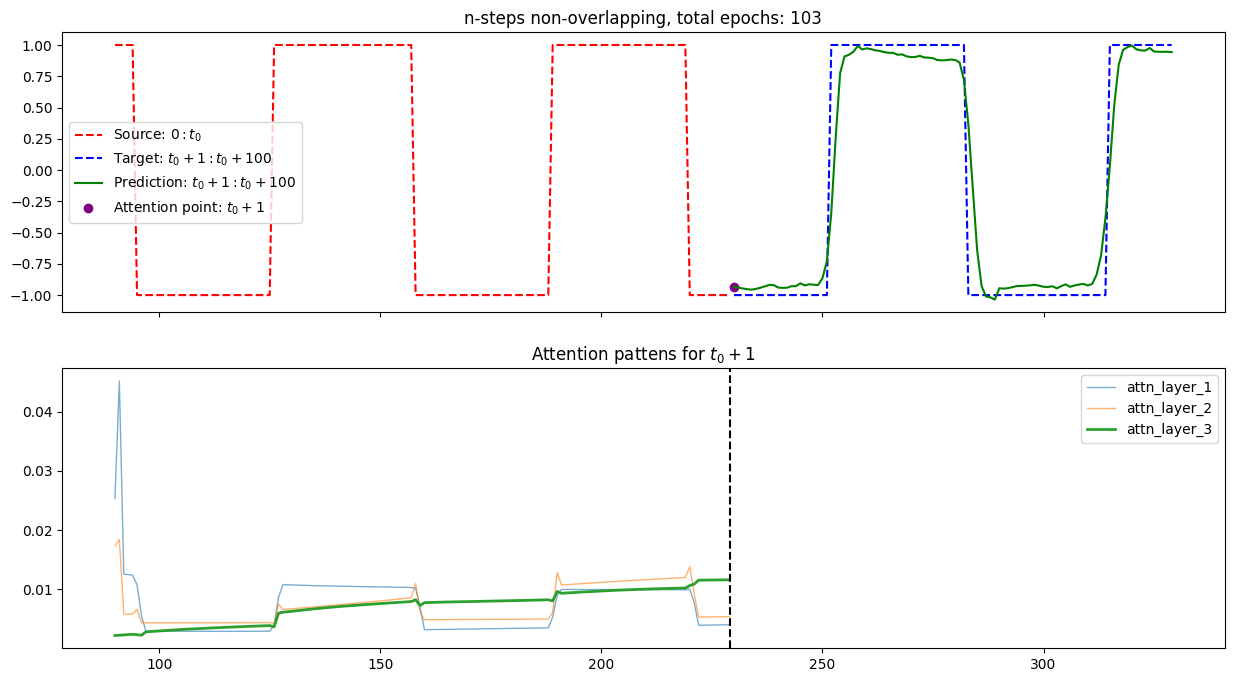

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Step function

In [58]:
DATASET_NAME = "step_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

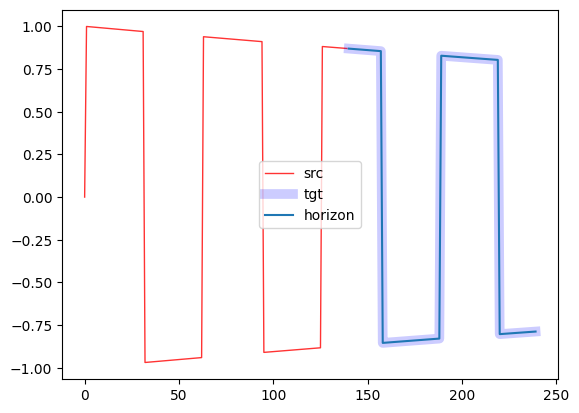

In [59]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [62]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [63]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
    
model = early_stopper.best_model        

epoch=0	train_loss=0.0961	val_loss=0.0594	train_mape_loss=9.4626	val_mape_loss=1.7901	R_p=['1.0219', '1.1091']
epoch=1	train_loss=0.0588	val_loss=0.0609	train_mape_loss=2.7612	val_mape_loss=3.7322	R_p=['1.0981', '1.3298']
epoch=2	train_loss=0.0586	val_loss=0.0600	train_mape_loss=2.5065	val_mape_loss=2.7594	R_p=['1.0572', '0.8940']
epoch=3	train_loss=0.0583	val_loss=0.0603	train_mape_loss=2.2163	val_mape_loss=3.1650	R_p=['1.0739', '1.2643']
epoch=4	train_loss=0.0578	val_loss=0.0591	train_mape_loss=1.9039	val_mape_loss=1.0490	R_p=['1.0008', '1.0218']
epoch=5	train_loss=0.0582	val_loss=0.0593	train_mape_loss=2.0048	val_mape_loss=1.6833	R_p=['1.0182', '1.0969']
epoch=6	train_loss=0.0584	val_loss=0.0591	train_mape_loss=2.4259	val_mape_loss=0.9998	R_p=['0.9999', '0.9987']
epoch=7	train_loss=0.0576	val_loss=0.0593	train_mape_loss=1.8899	val_mape_loss=1.6860	R_p=['1.0183', '1.0973']
epoch=8	train_loss=0.0576	val_loss=0.0593	train_mape_loss=1.7872	val_mape_loss=1.7793	R_p=['1.0214', '1.1076']
e

In [64]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [65]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.0056876235753297805,
 1.054660312652588,
 [0.2184380441904068, 0.2689738869667053])

#### Predict

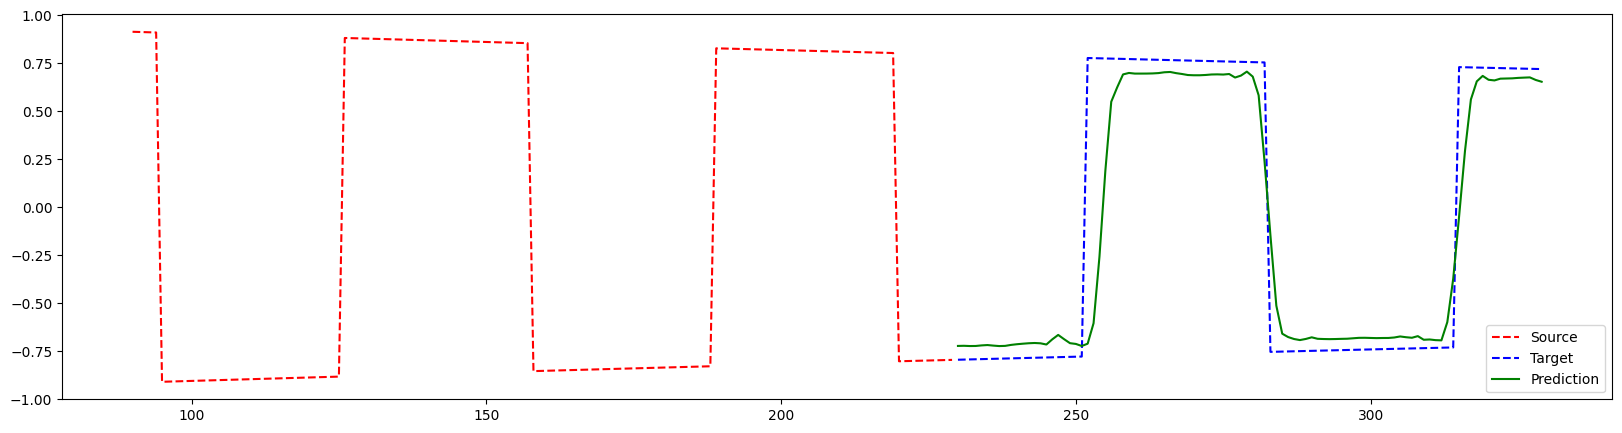

In [66]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [67]:
inspect_step = 0

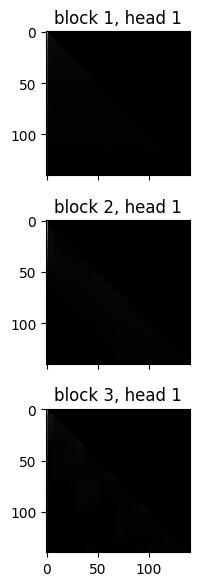

In [68]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

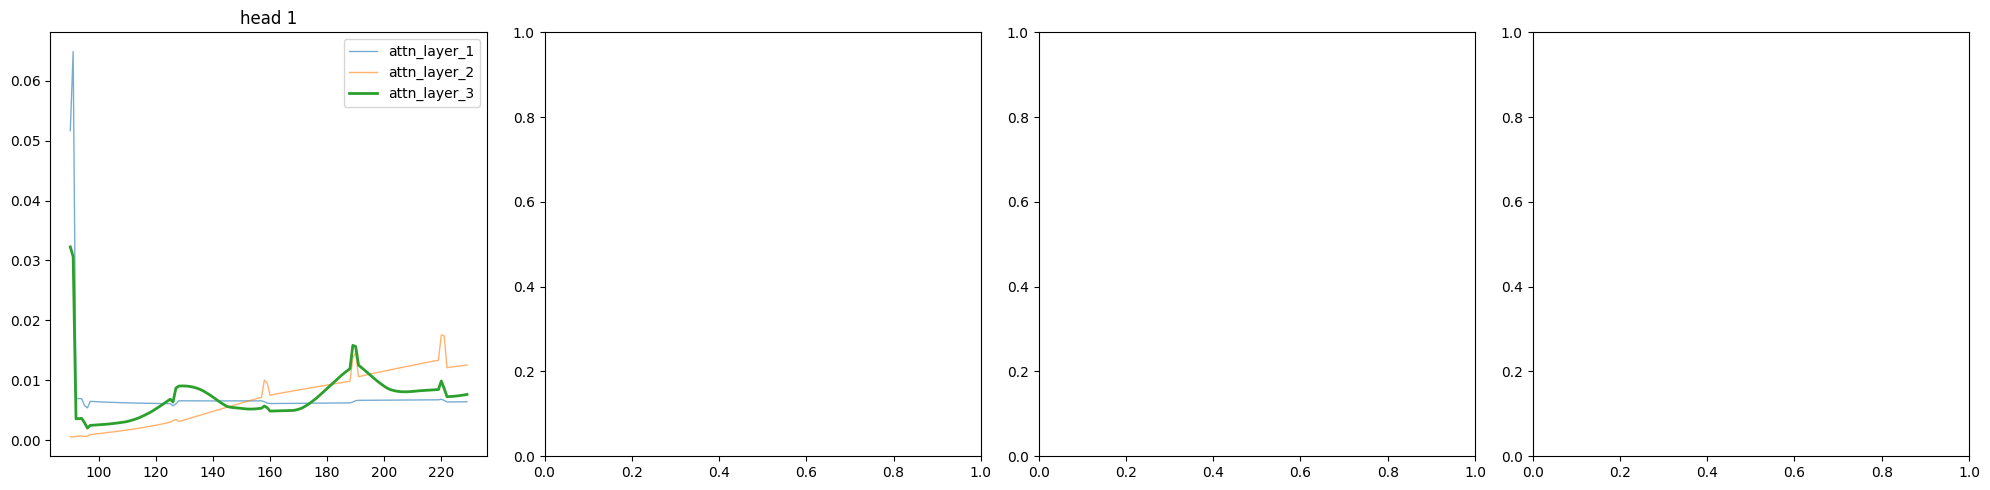

In [69]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

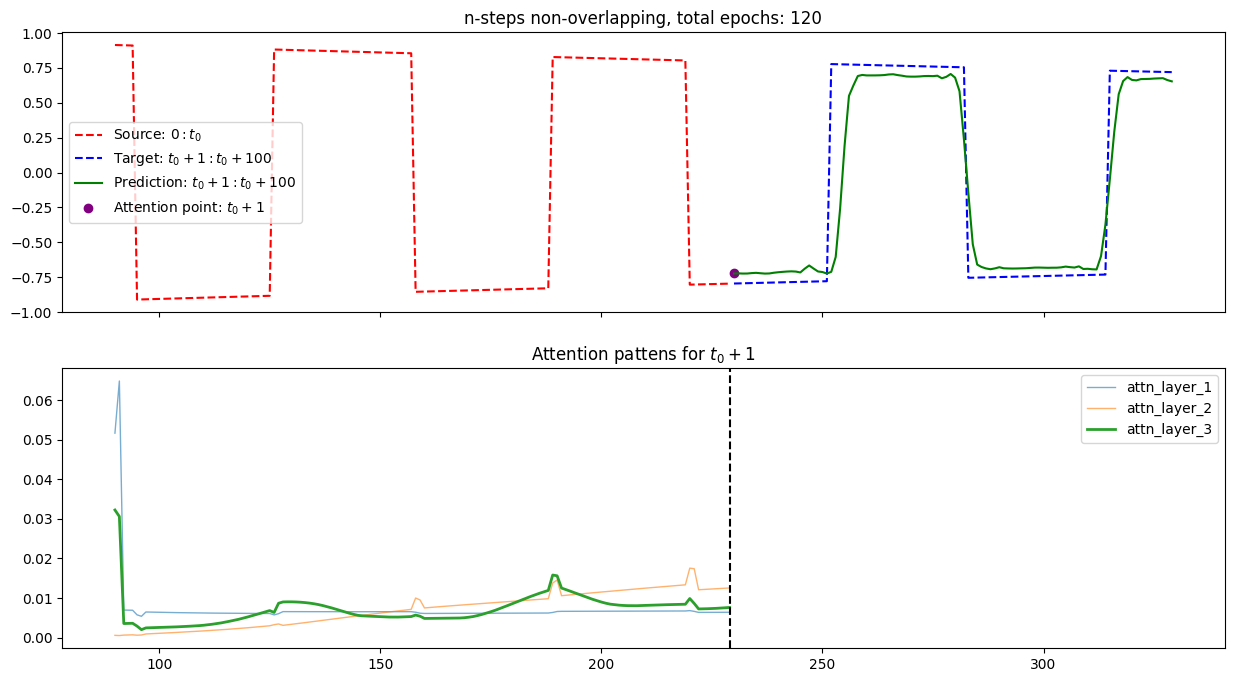

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Step function

In [71]:
DATASET_NAME = "step_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

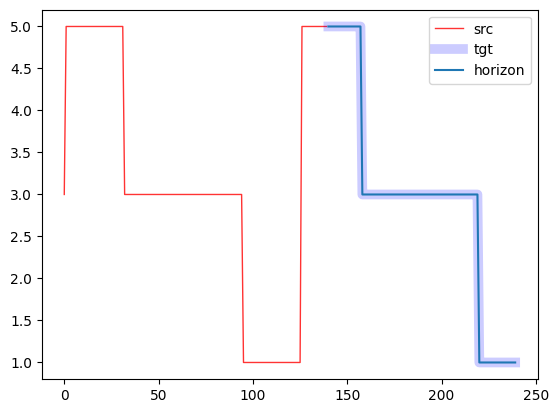

In [72]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [75]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [76]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
           
model = early_stopper.best_model 

epoch=0	train_loss=2.1697	val_loss=2.0810	train_mape_loss=0.6388	val_mape_loss=0.5941	R_p=['0.3756', '0.4419']
epoch=1	train_loss=2.0166	val_loss=2.1122	train_mape_loss=0.6138	val_mape_loss=0.5921	R_p=['0.3849', '0.4662']
epoch=2	train_loss=2.0093	val_loss=2.0808	train_mape_loss=0.6108	val_mape_loss=0.5941	R_p=['0.3755', '0.4417']
epoch=3	train_loss=2.0077	val_loss=2.1706	train_mape_loss=0.6094	val_mape_loss=0.5893	R_p=['0.3989', '0.5025']
epoch=4	train_loss=2.0106	val_loss=2.1119	train_mape_loss=0.6089	val_mape_loss=0.5921	R_p=['0.3848', '0.4660']
epoch=5	train_loss=2.0072	val_loss=2.0817	train_mape_loss=0.6088	val_mape_loss=0.5940	R_p=['0.3758', '0.4426']
epoch=6	train_loss=2.0046	val_loss=2.1260	train_mape_loss=0.6066	val_mape_loss=0.5914	R_p=['0.3885', '0.4756']
epoch=7	train_loss=2.0056	val_loss=2.1024	train_mape_loss=0.6075	val_mape_loss=0.5927	R_p=['0.3822', '0.4592']
epoch=8	train_loss=2.0066	val_loss=2.0918	train_mape_loss=0.6090	val_mape_loss=0.5933	R_p=['0.3791', '0.4510']
e

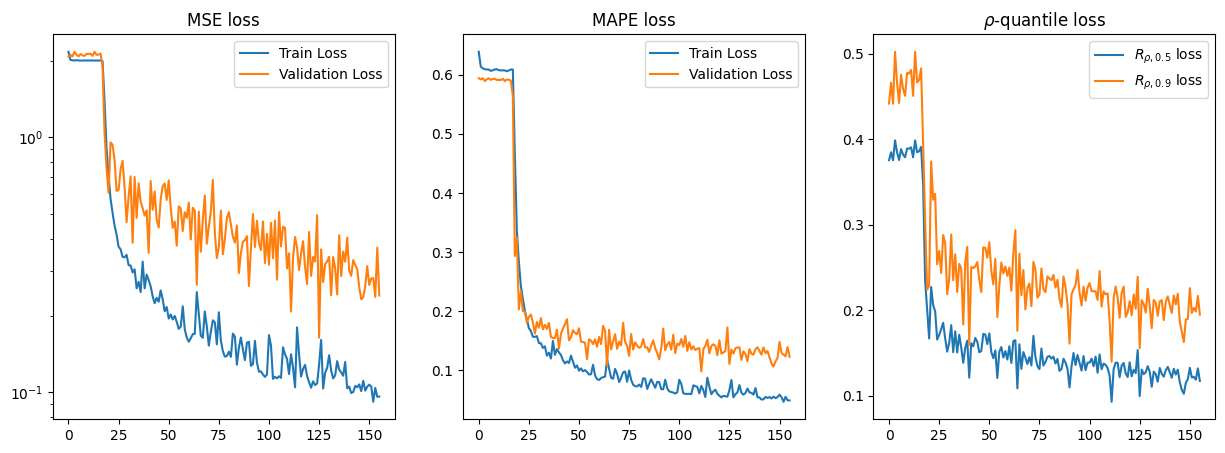

In [77]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [78]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.1762048922777176,
 0.11183968621492386,
 [0.10095688700675964, 0.15787765383720398])

#### Predict

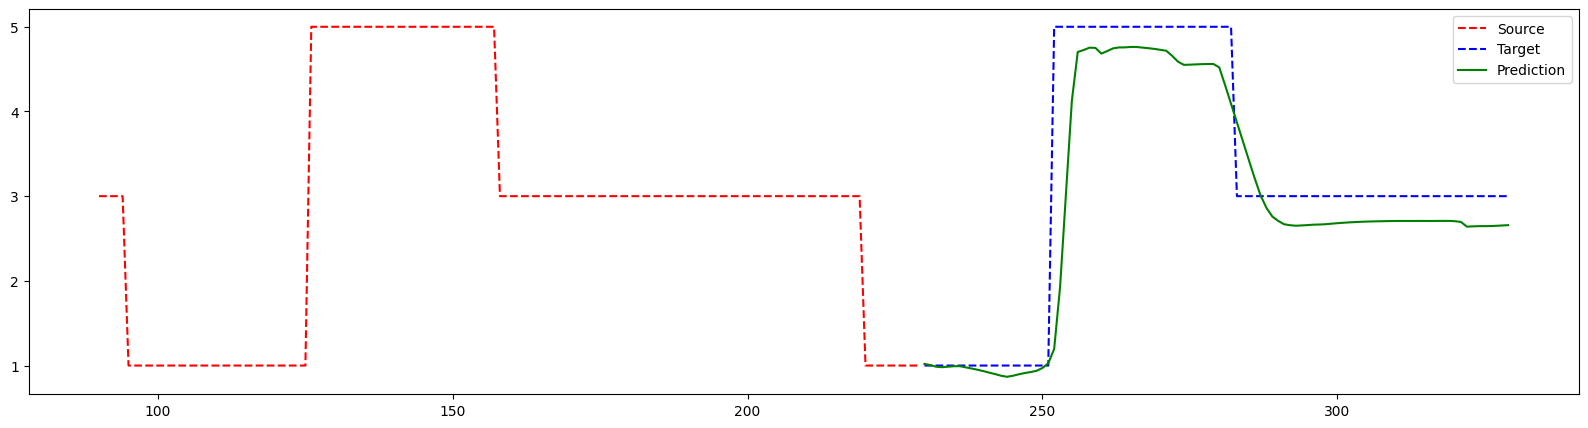

In [79]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [80]:
inspect_step = 0

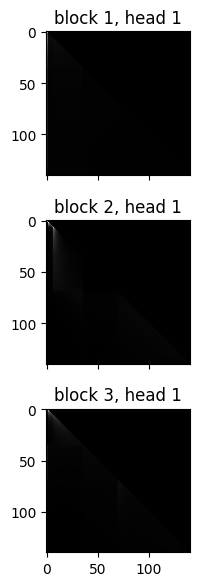

In [81]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

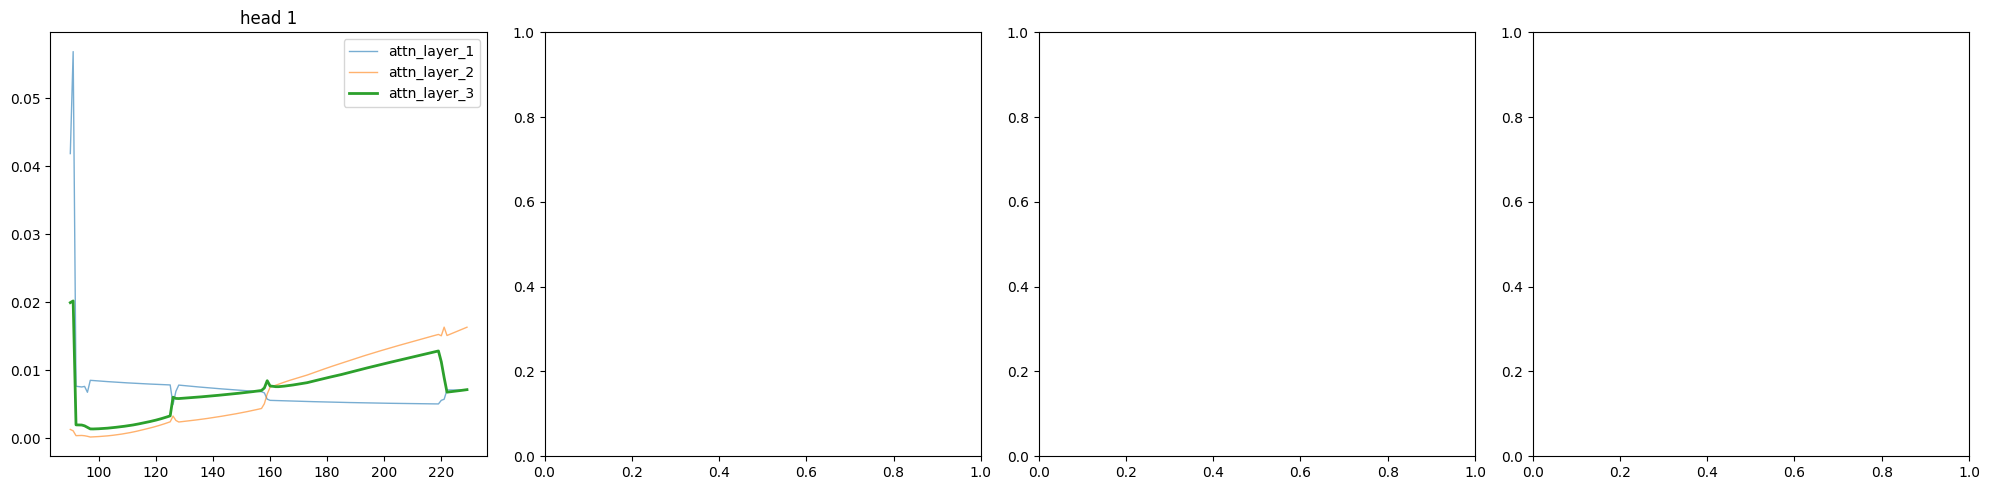

In [82]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

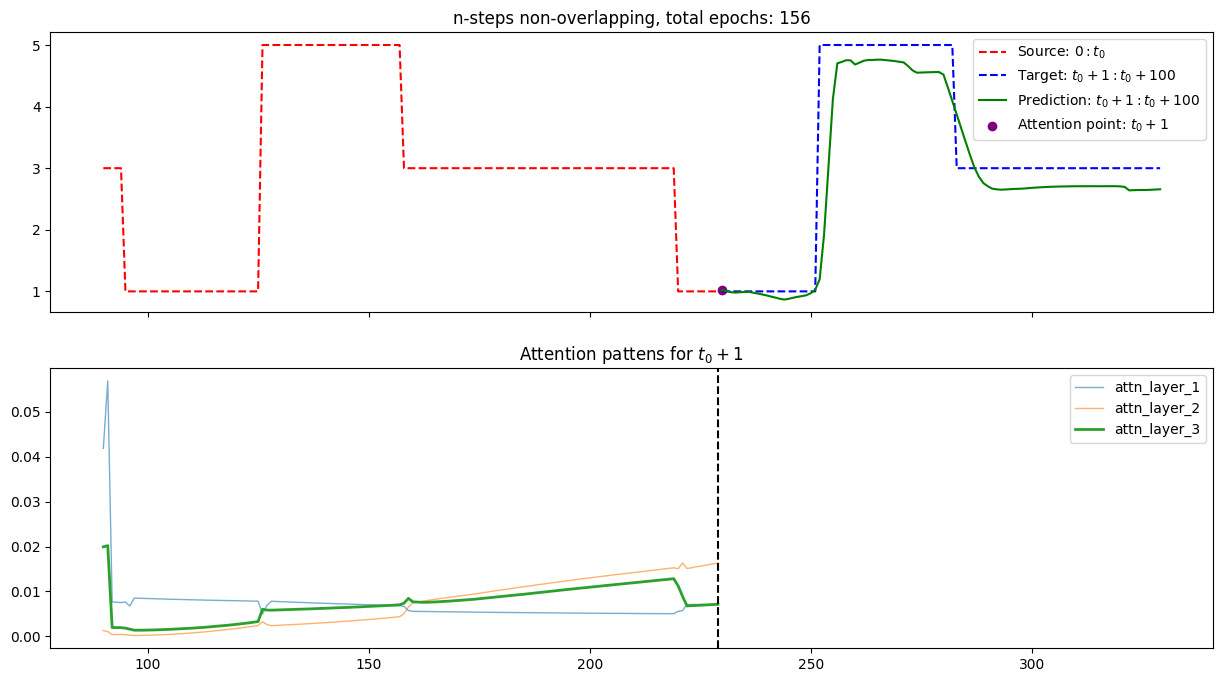

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 6: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target

### Sine function

In [84]:
DATASET_NAME = "sine"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

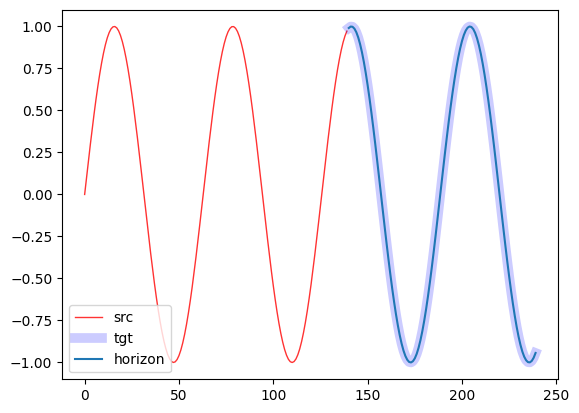

In [85]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [88]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [89]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
  
model = early_stopper.best_model          

epoch=0	train_loss=0.5221	val_loss=0.5027	train_mape_loss=1.7391	val_mape_loss=1.5335	R_p=['1.0020', '1.0761']
epoch=1	train_loss=0.5030	val_loss=0.4997	train_mape_loss=1.2841	val_mape_loss=1.2614	R_p=['1.0000', '0.9704']
epoch=2	train_loss=0.5031	val_loss=0.5000	train_mape_loss=1.3288	val_mape_loss=1.2250	R_p=['1.0004', '1.0366']
epoch=3	train_loss=0.5015	val_loss=0.4994	train_mape_loss=1.2163	val_mape_loss=1.0985	R_p=['1.0000', '1.0198']
epoch=4	train_loss=0.5014	val_loss=0.5004	train_mape_loss=1.2183	val_mape_loss=1.3047	R_p=['1.0006', '1.0469']
epoch=5	train_loss=0.5020	val_loss=0.5013	train_mape_loss=1.2834	val_mape_loss=1.5129	R_p=['1.0006', '0.9399']
epoch=6	train_loss=0.5009	val_loss=0.5036	train_mape_loss=1.2029	val_mape_loss=1.6404	R_p=['1.0023', '1.0896']
epoch=7	train_loss=0.5012	val_loss=0.4996	train_mape_loss=1.2138	val_mape_loss=1.3581	R_p=['0.9995', '0.9580']
epoch=8	train_loss=0.5002	val_loss=0.4968	train_mape_loss=1.2081	val_mape_loss=1.3063	R_p=['0.9969', '1.0448']
e

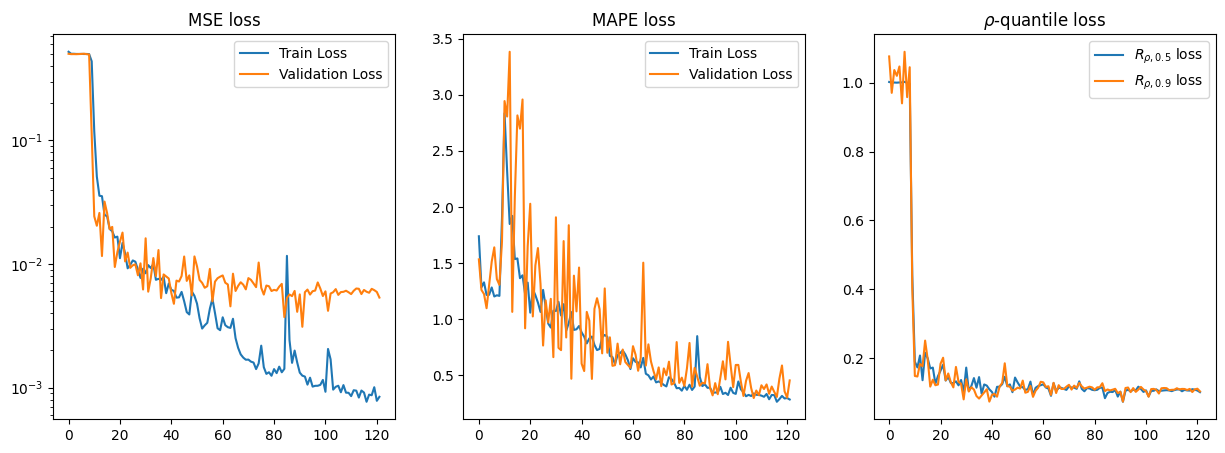

In [90]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [91]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.00637470393255353,
 0.3464095423221588,
 [0.09702172130346298, 0.08785135298967361])

#### Predict

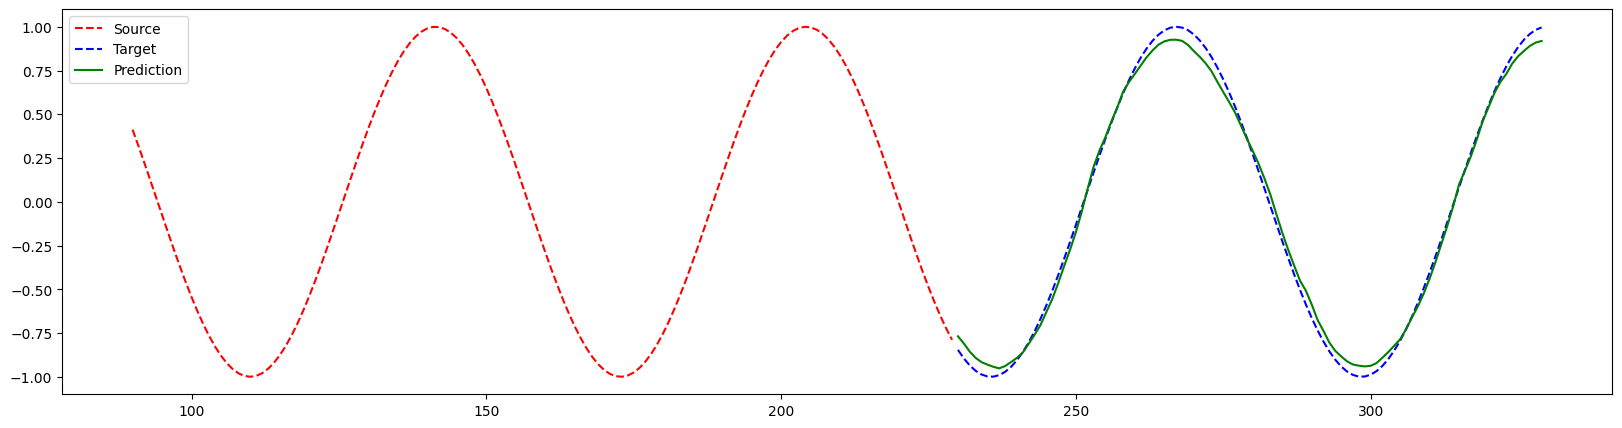

In [92]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [93]:
inspect_step = 0

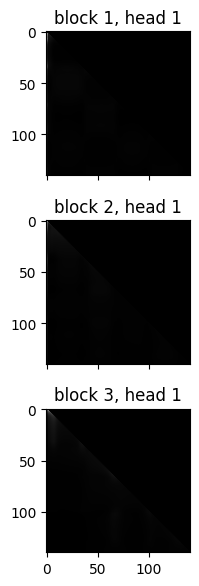

In [94]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

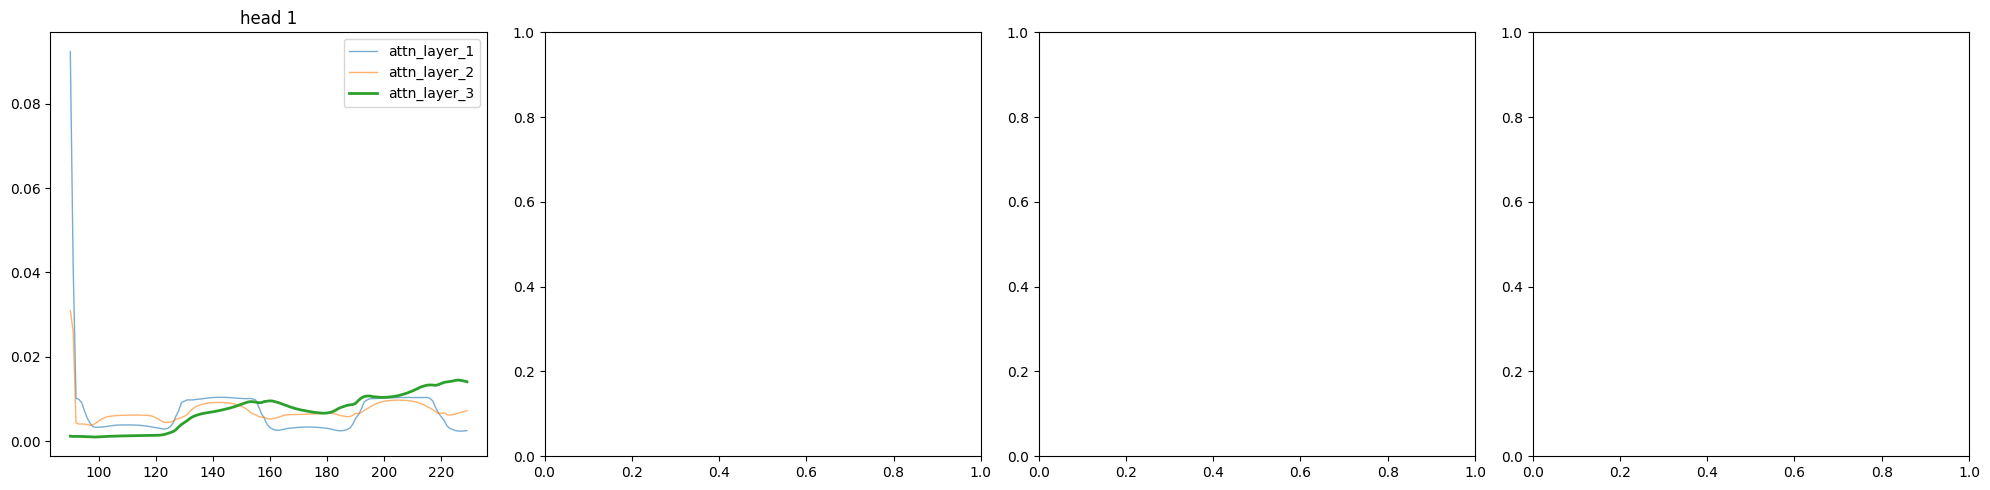

In [95]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

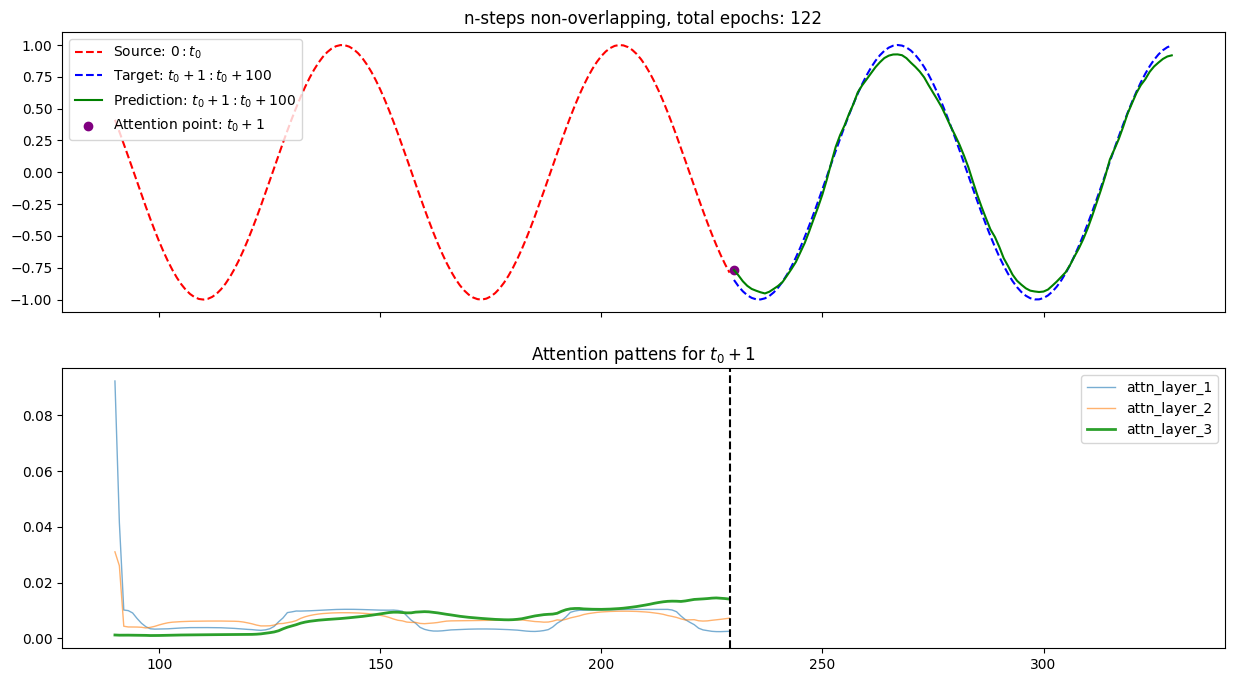

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sine function

In [97]:
DATASET_NAME = "sine_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

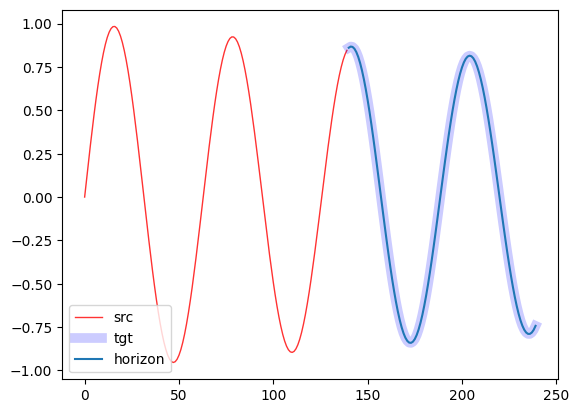

In [98]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [101]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [102]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
 
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
  
model = early_stopper.best_model          

epoch=0	train_loss=0.0542	val_loss=0.0252	train_mape_loss=50.0466	val_mape_loss=9.2292	R_p=['1.0569', '1.1772']
epoch=1	train_loss=0.0291	val_loss=0.0251	train_mape_loss=14.3060	val_mape_loss=4.4783	R_p=['1.0172', '0.9165']
epoch=2	train_loss=0.0291	val_loss=0.0257	train_mape_loss=12.0850	val_mape_loss=16.9730	R_p=['1.1452', '1.4015']
epoch=3	train_loss=0.0292	val_loss=0.0250	train_mape_loss=13.3493	val_mape_loss=3.9913	R_p=['1.0120', '1.0396']
epoch=4	train_loss=0.0286	val_loss=0.0251	train_mape_loss=9.4424	val_mape_loss=5.1649	R_p=['1.0205', '1.0692']
epoch=5	train_loss=0.0284	val_loss=0.0254	train_mape_loss=10.4144	val_mape_loss=9.1910	R_p=['1.0606', '0.8760']
epoch=6	train_loss=0.0284	val_loss=0.0252	train_mape_loss=10.6891	val_mape_loss=9.5793	R_p=['1.0605', '1.1874']
epoch=7	train_loss=0.0282	val_loss=0.0250	train_mape_loss=6.8433	val_mape_loss=1.9788	R_p=['1.0013', '0.9911']
epoch=8	train_loss=0.0283	val_loss=0.0253	train_mape_loss=8.1730	val_mape_loss=8.6637	R_p=['1.0550', '0.8

In [103]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [104]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.0004489209456369281,
 2.594678388595581,
 [0.1228267177939415, 0.09923992305994034])

#### Predict

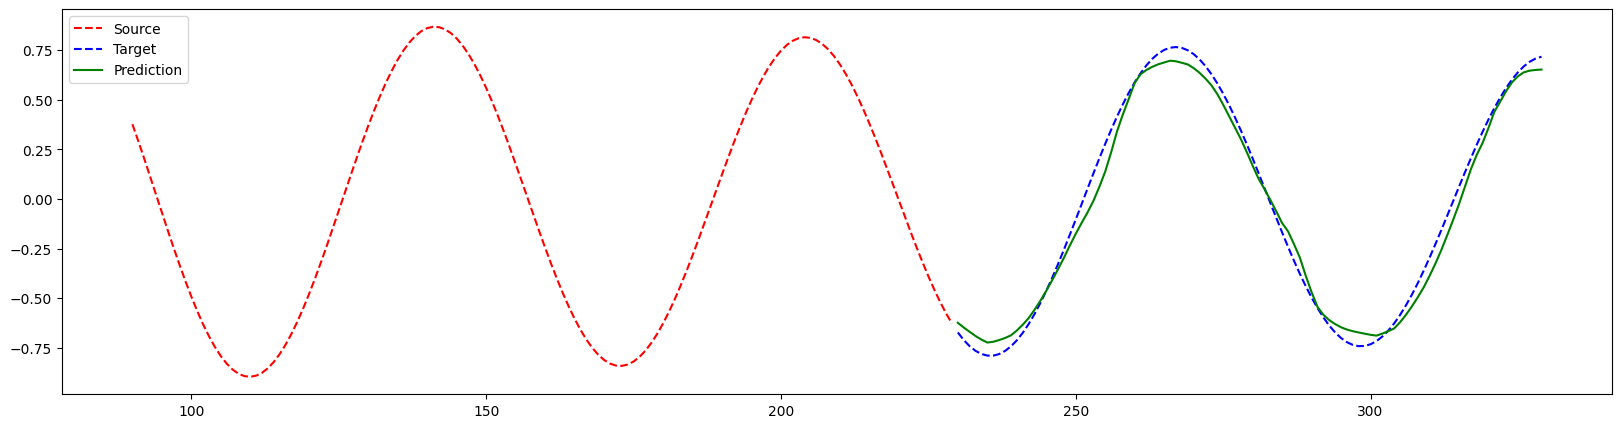

In [105]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [106]:
inspect_step = 0

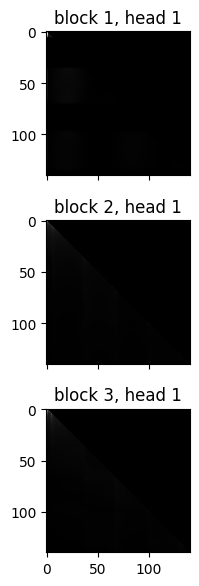

In [107]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

In [108]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

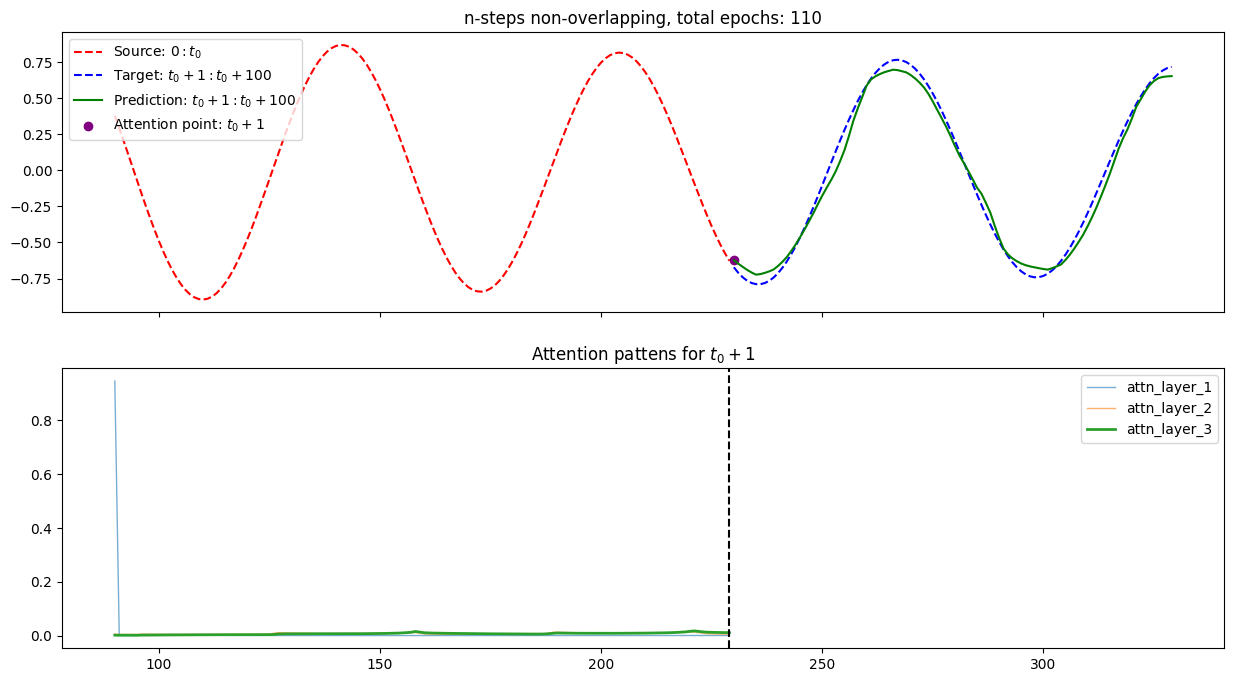

In [109]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sine function

In [110]:
DATASET_NAME = "sine_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

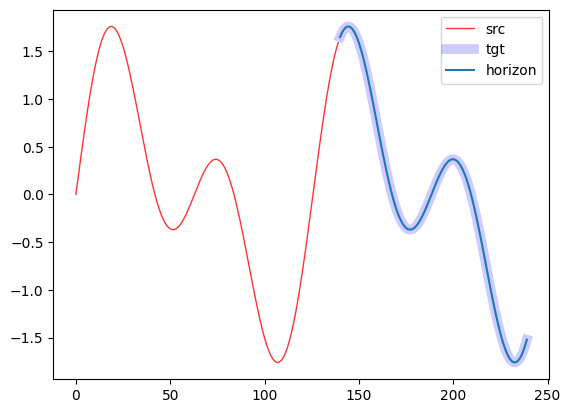

In [111]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [114]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [115]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
          
model = early_stopper.best_model  

epoch=0	train_loss=1.0341	val_loss=1.0134	train_mape_loss=1.6091	val_mape_loss=1.0057	R_p=['1.0000', '1.0091']
epoch=1	train_loss=1.0059	val_loss=1.0261	train_mape_loss=1.2103	val_mape_loss=1.5387	R_p=['1.0067', '0.8941']
epoch=2	train_loss=1.0057	val_loss=1.0174	train_mape_loss=1.2092	val_mape_loss=1.2853	R_p=['1.0022', '0.9383']
epoch=3	train_loss=1.0044	val_loss=1.0134	train_mape_loss=1.1816	val_mape_loss=1.0058	R_p=['1.0000', '1.0093']
epoch=4	train_loss=1.0027	val_loss=1.0136	train_mape_loss=1.1122	val_mape_loss=1.0758	R_p=['1.0001', '0.9821']
epoch=5	train_loss=1.0033	val_loss=1.0140	train_mape_loss=1.1200	val_mape_loss=1.1190	R_p=['1.0004', '0.9720']
epoch=6	train_loss=1.0031	val_loss=1.0132	train_mape_loss=1.1268	val_mape_loss=1.0001	R_p=['0.9999', '1.0058']
epoch=7	train_loss=1.0034	val_loss=1.0133	train_mape_loss=1.1417	val_mape_loss=1.0573	R_p=['1.0000', '0.9866']
epoch=8	train_loss=1.0027	val_loss=1.0135	train_mape_loss=1.1111	val_mape_loss=1.0373	R_p=['1.0000', '1.0191']
e

In [116]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [117]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.0358199277818203,
 0.8245757551193237,
 [0.18015599250793457, 0.22259052097797394])

#### Predict

In [118]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [119]:
inspect_step = 0

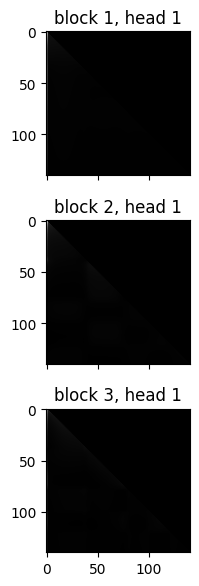

In [120]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

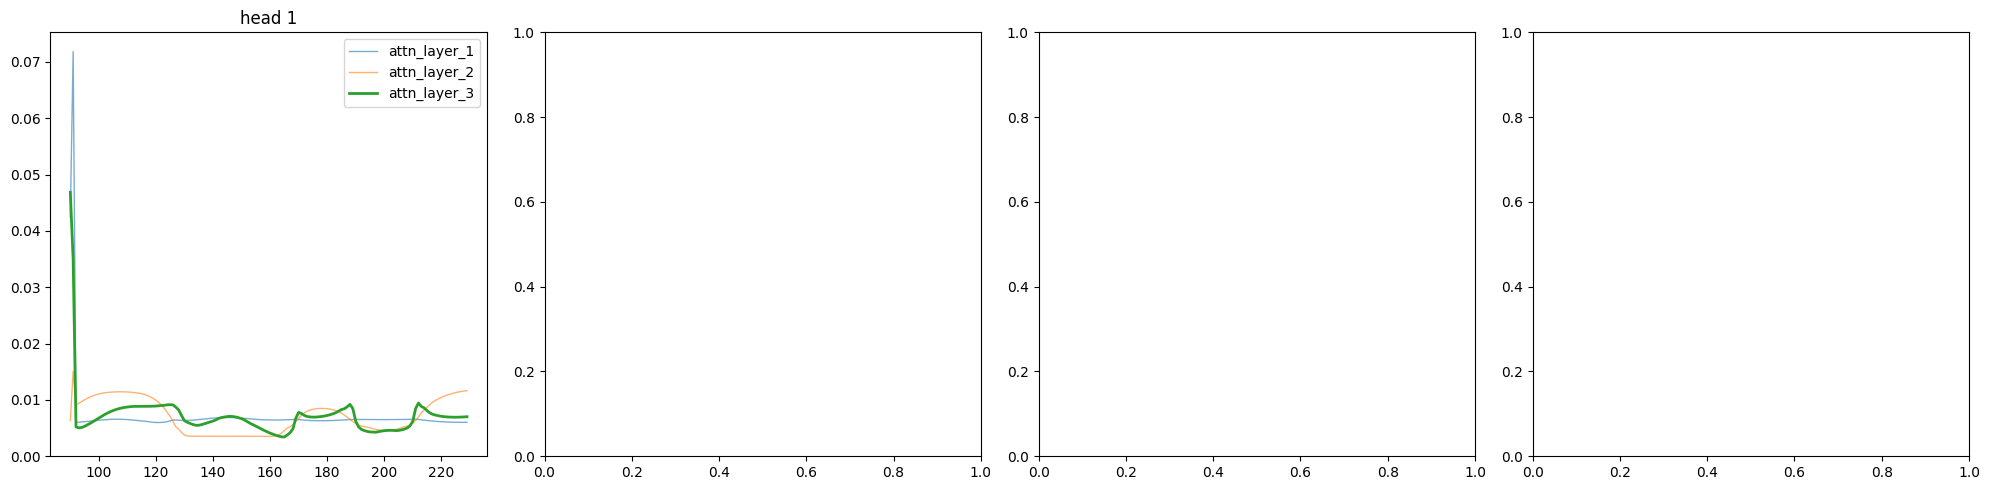

In [121]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

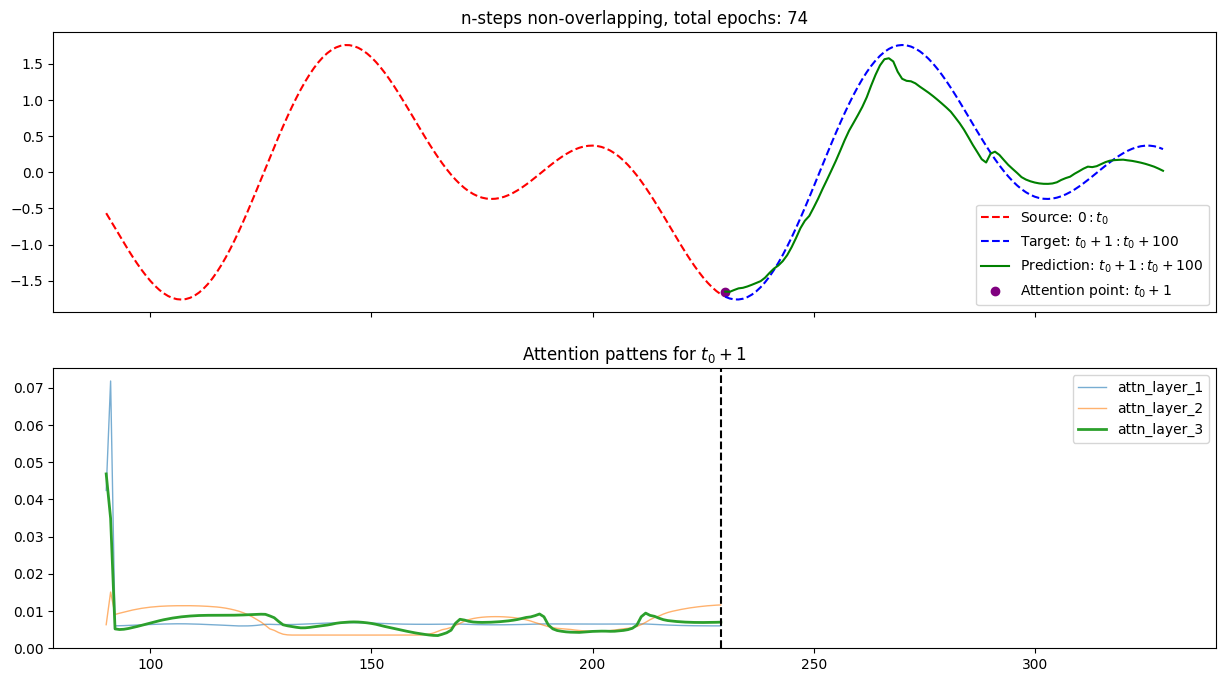

In [122]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 7: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

### Sawtooth function

In [123]:
DATASET_NAME = "sawtooth"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

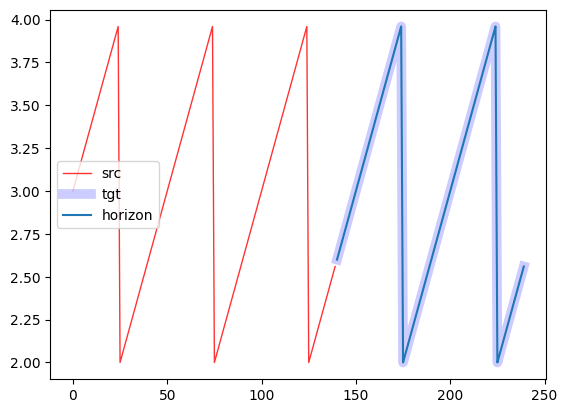

In [124]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [127]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [128]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
  
model = early_stopper.best_model          

epoch=0	train_loss=0.4918	val_loss=0.4039	train_mape_loss=0.2012	val_mape_loss=0.1743	R_p=['0.1796', '0.2510']
epoch=1	train_loss=0.3404	val_loss=0.4308	train_mape_loss=0.1792	val_mape_loss=0.1763	R_p=['0.1841', '0.2680']
epoch=2	train_loss=0.3372	val_loss=0.4161	train_mape_loss=0.1786	val_mape_loss=0.1752	R_p=['0.1817', '0.2590']
epoch=3	train_loss=0.3523	val_loss=0.4057	train_mape_loss=0.1810	val_mape_loss=0.1744	R_p=['0.1799', '0.2522']
epoch=4	train_loss=0.3401	val_loss=0.4092	train_mape_loss=0.1792	val_mape_loss=0.1747	R_p=['0.1805', '0.2546']
epoch=5	train_loss=0.3361	val_loss=0.4031	train_mape_loss=0.1784	val_mape_loss=0.1742	R_p=['0.1795', '0.2505']
epoch=6	train_loss=0.3667	val_loss=0.4460	train_mape_loss=0.1836	val_mape_loss=0.1776	R_p=['0.1867', '0.2769']
epoch=7	train_loss=0.3418	val_loss=0.4073	train_mape_loss=0.1790	val_mape_loss=0.1745	R_p=['0.1802', '0.2533']
epoch=8	train_loss=0.3390	val_loss=0.4080	train_mape_loss=0.1789	val_mape_loss=0.1746	R_p=['0.1803', '0.2538']
e

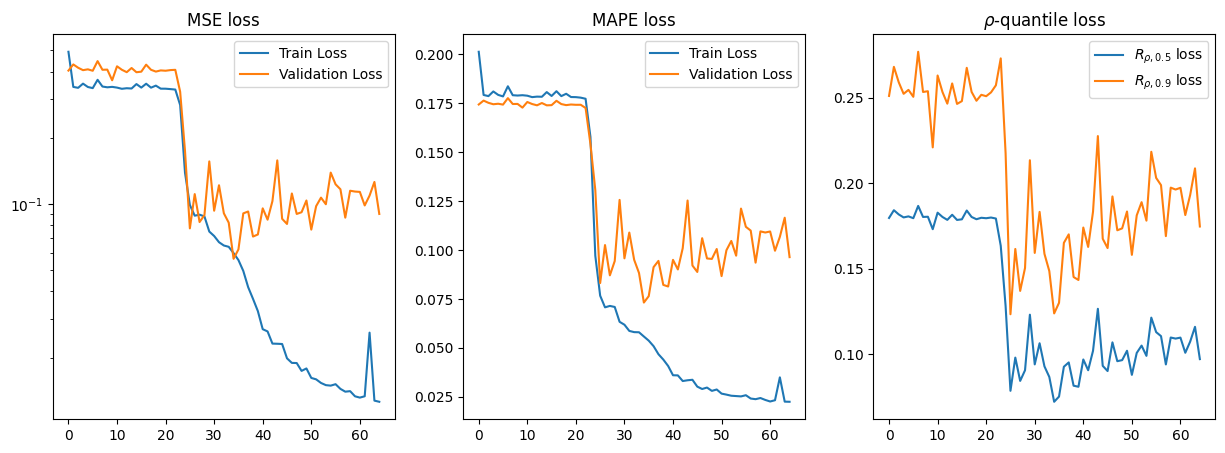

In [129]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [130]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.05667352277040481,
 0.07359680706262589,
 [0.07245663553476334, 0.12470557540655136])

#### Predict

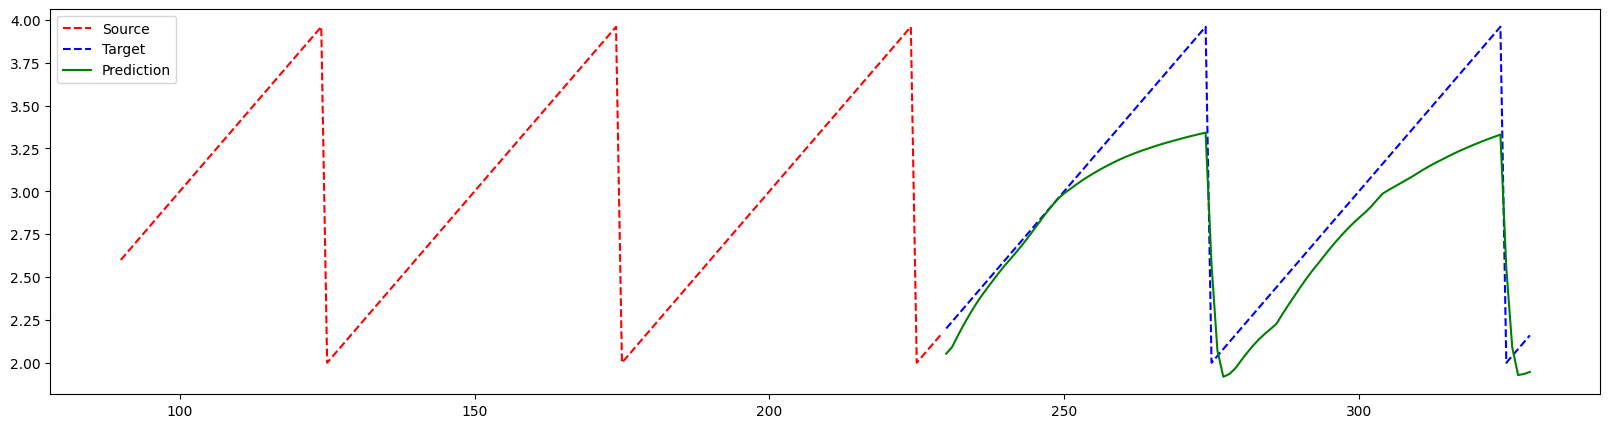

In [131]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [132]:
inspect_step = 0

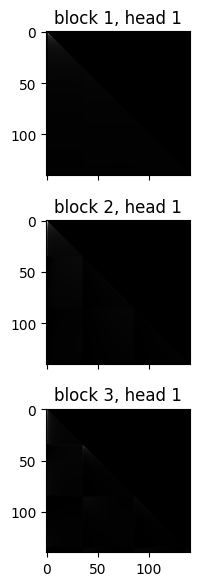

In [133]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

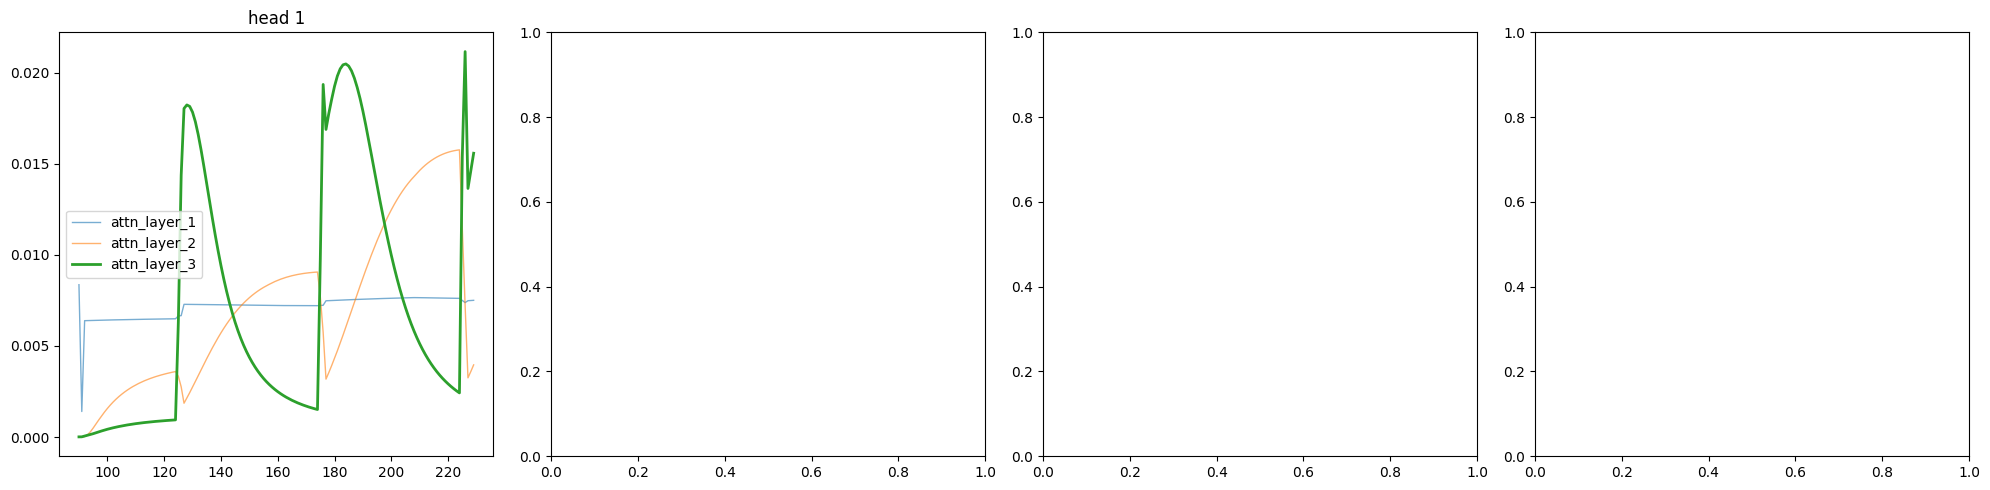

In [134]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

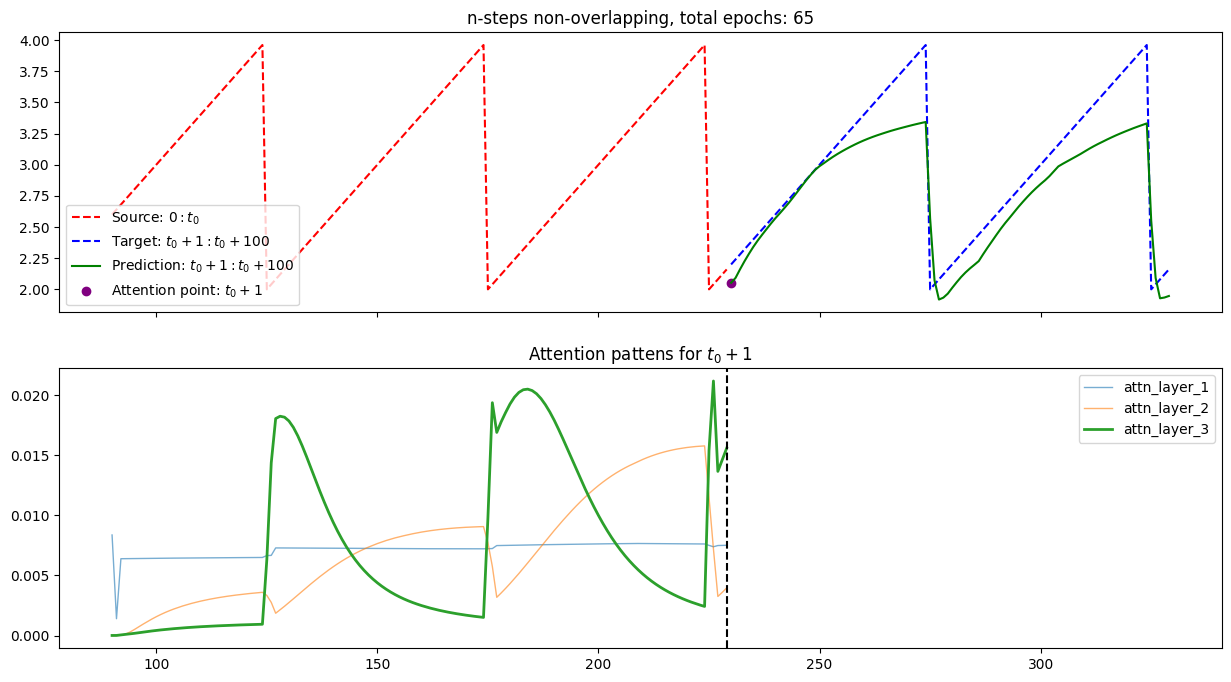

In [135]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sawtooth function

In [136]:
DATASET_NAME = "sawtooth_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

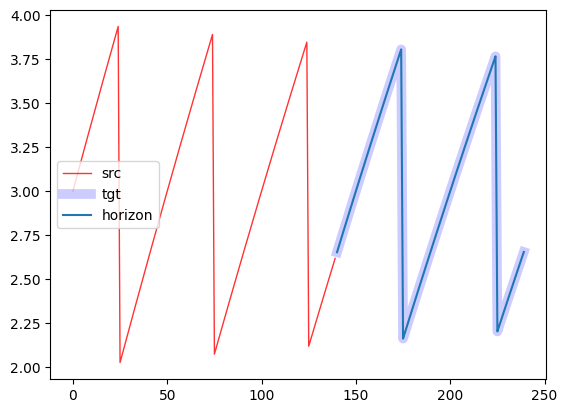

In [137]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [140]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [141]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
       
model = early_stopper.best_model     

epoch=0	train_loss=0.2732	val_loss=0.0711	train_mape_loss=0.0939	val_mape_loss=0.0810	R_p=['0.0819', '0.1441']
epoch=1	train_loss=0.0321	val_loss=0.1195	train_mape_loss=0.0400	val_mape_loss=0.1080	R_p=['0.1092', '0.1947']
epoch=2	train_loss=0.0263	val_loss=0.1026	train_mape_loss=0.0347	val_mape_loss=0.0995	R_p=['0.1006', '0.1788']
epoch=3	train_loss=0.0209	val_loss=0.1039	train_mape_loss=0.0286	val_mape_loss=0.1001	R_p=['0.1012', '0.1800']
epoch=4	train_loss=0.0227	val_loss=0.0653	train_mape_loss=0.0299	val_mape_loss=0.0772	R_p=['0.0781', '0.1369']
epoch=5	train_loss=0.0214	val_loss=0.0605	train_mape_loss=0.0284	val_mape_loss=0.0739	R_p=['0.0747', '0.1305']
epoch=6	train_loss=0.0207	val_loss=0.0950	train_mape_loss=0.0277	val_mape_loss=0.0953	R_p=['0.0964', '0.1710']
epoch=7	train_loss=0.0198	val_loss=0.0988	train_mape_loss=0.0257	val_mape_loss=0.0974	R_p=['0.0985', '0.1749']
epoch=8	train_loss=0.0196	val_loss=0.0992	train_mape_loss=0.0252	val_mape_loss=0.0976	R_p=['0.0987', '0.1753']
e

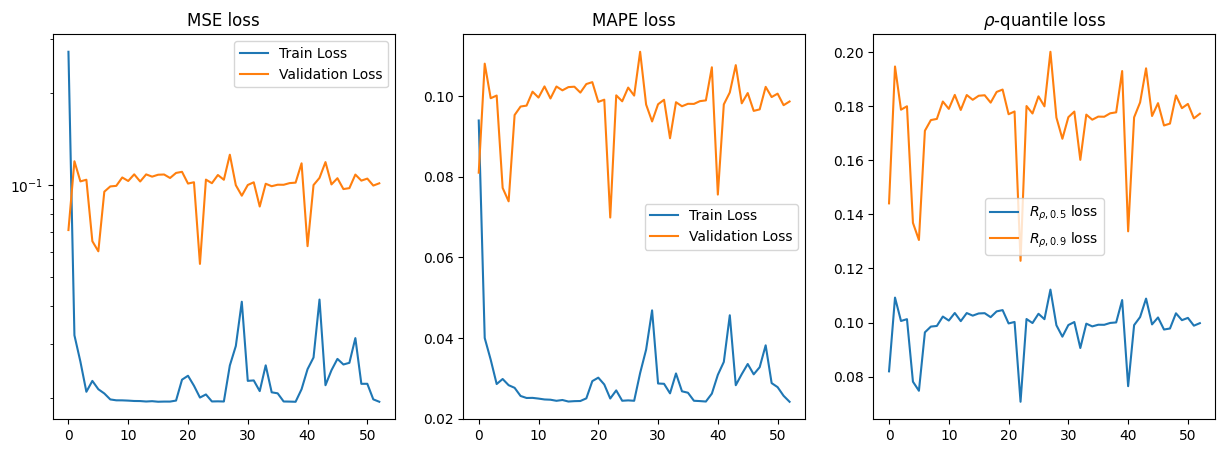

In [142]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [143]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.05723488321900368,
 0.07068137955665589,
 [0.0714896097779274, 0.12359826266765594])

#### Predict

In [144]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [145]:
inspect_step = 0

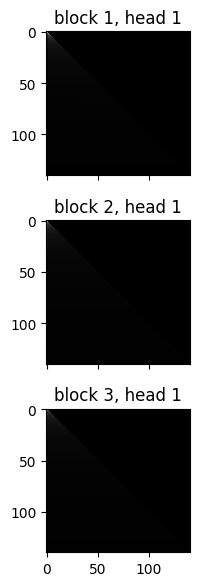

In [146]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

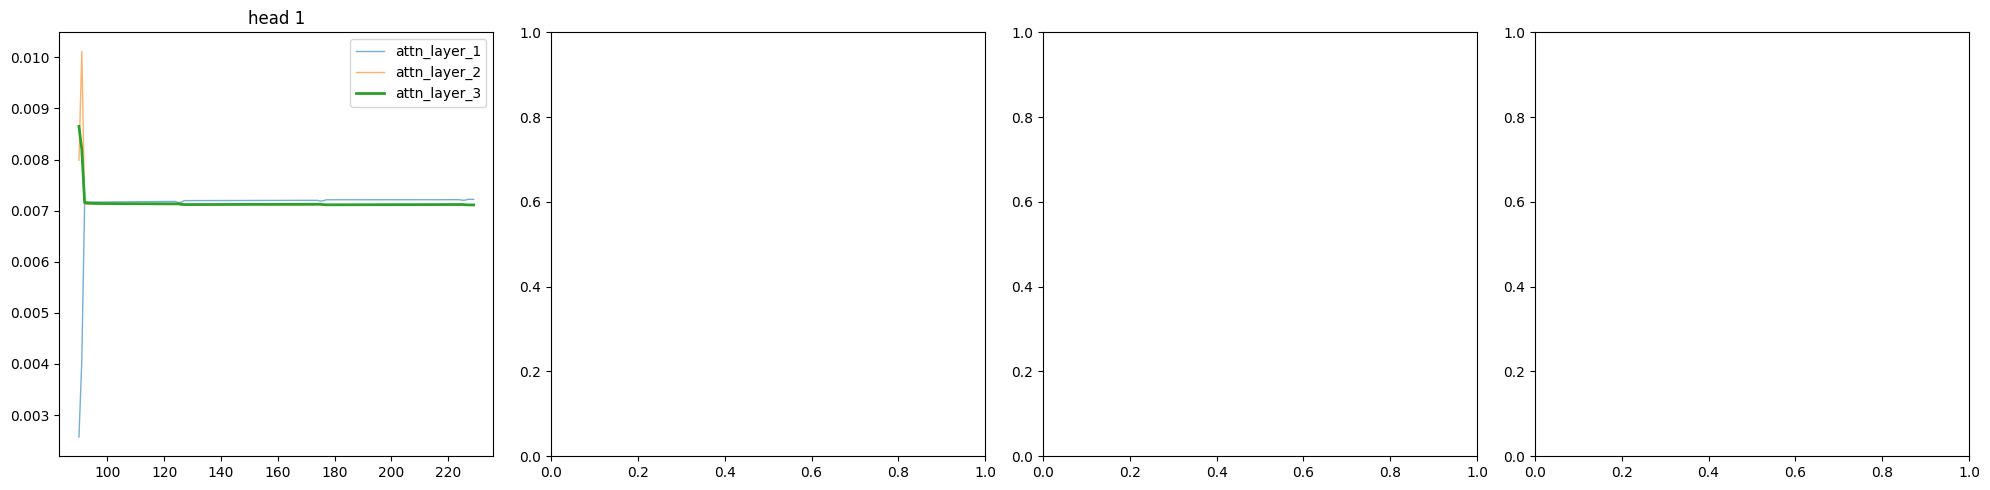

In [147]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

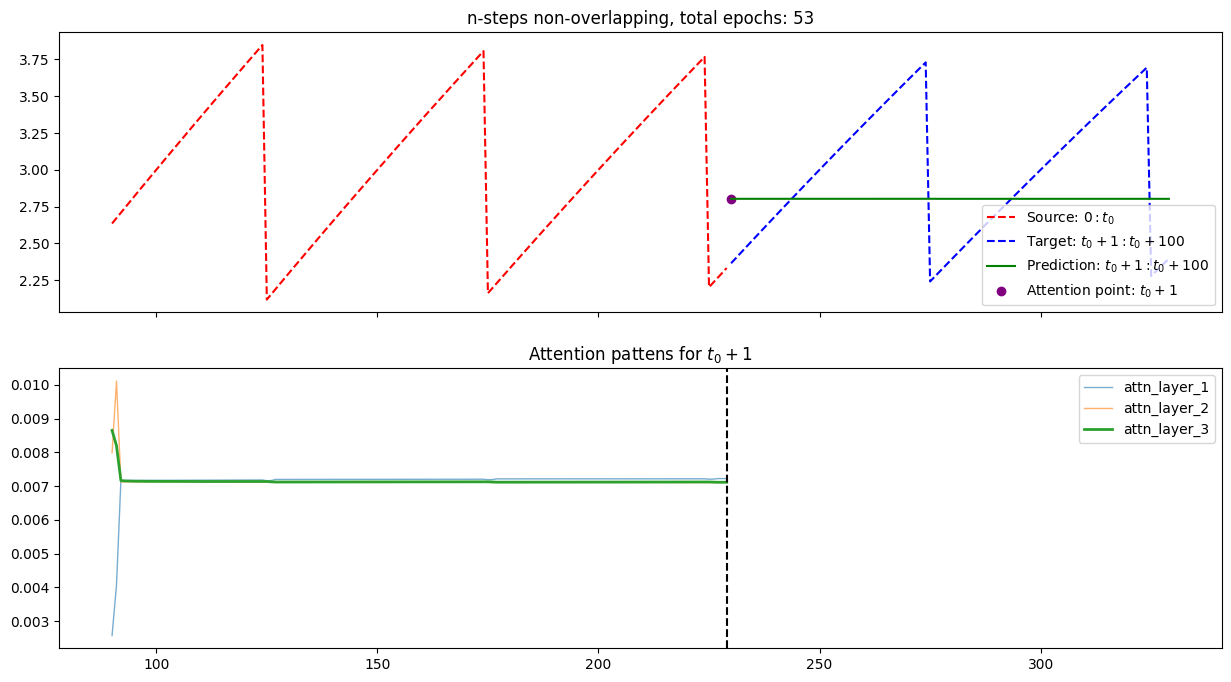

In [148]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sawtooth function

In [149]:
DATASET_NAME = "sawtooth_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

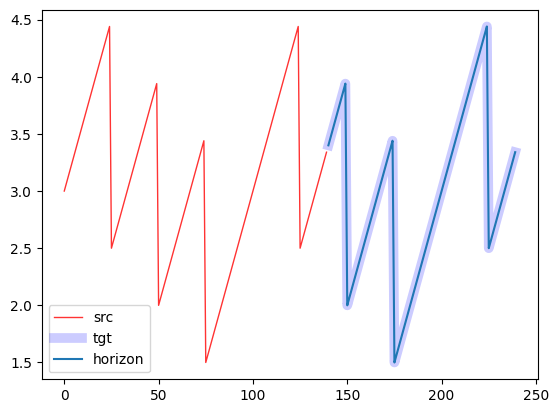

In [150]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [153]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

#### Training

In [154]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

model = early_stopper.best_model

epoch=0	train_loss=0.6393	val_loss=0.5200	train_mape_loss=0.2393	val_mape_loss=0.2124	R_p=['0.1998', '0.2382']
epoch=1	train_loss=0.5116	val_loss=0.5920	train_mape_loss=0.2215	val_mape_loss=0.2131	R_p=['0.2119', '0.2938']
epoch=2	train_loss=0.5124	val_loss=0.5846	train_mape_loss=0.2214	val_mape_loss=0.2127	R_p=['0.2106', '0.2891']
epoch=3	train_loss=0.5075	val_loss=0.5453	train_mape_loss=0.2207	val_mape_loss=0.2116	R_p=['0.2040', '0.2616']
epoch=4	train_loss=0.5209	val_loss=0.5776	train_mape_loss=0.2228	val_mape_loss=0.2124	R_p=['0.2095', '0.2847']
epoch=5	train_loss=0.5089	val_loss=0.5861	train_mape_loss=0.2208	val_mape_loss=0.2128	R_p=['0.2109', '0.2901']
epoch=6	train_loss=0.5007	val_loss=0.5807	train_mape_loss=0.2197	val_mape_loss=0.2125	R_p=['0.2100', '0.2867']
epoch=7	train_loss=0.5075	val_loss=0.5593	train_mape_loss=0.2207	val_mape_loss=0.2117	R_p=['0.2064', '0.2722']
epoch=8	train_loss=0.5036	val_loss=0.5766	train_mape_loss=0.2200	val_mape_loss=0.2123	R_p=['0.2093', '0.2840']
e

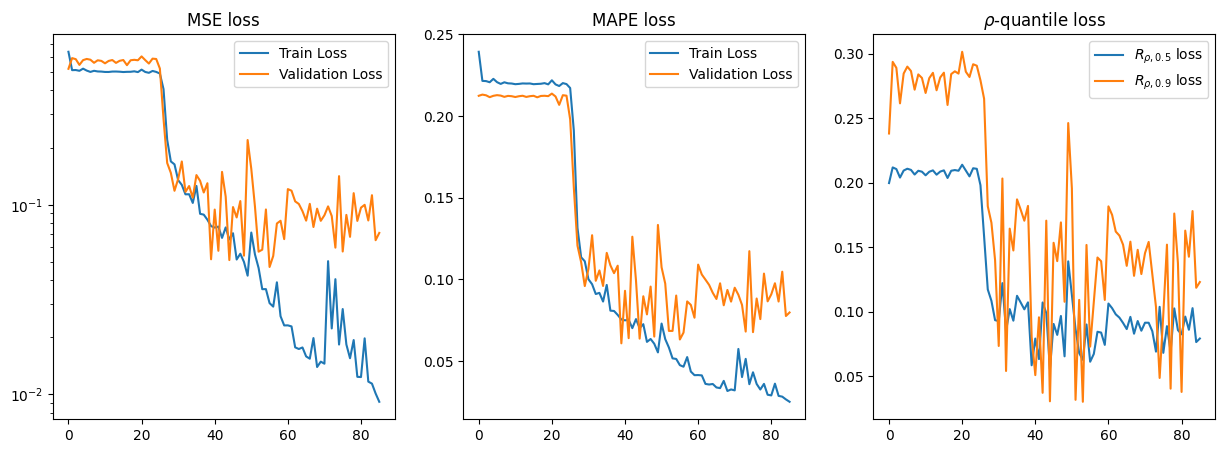

In [155]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [156]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.12456470596790313,
 0.10485557860136033,
 [0.09544139355421066, 0.05414362624287605])

#### Predict

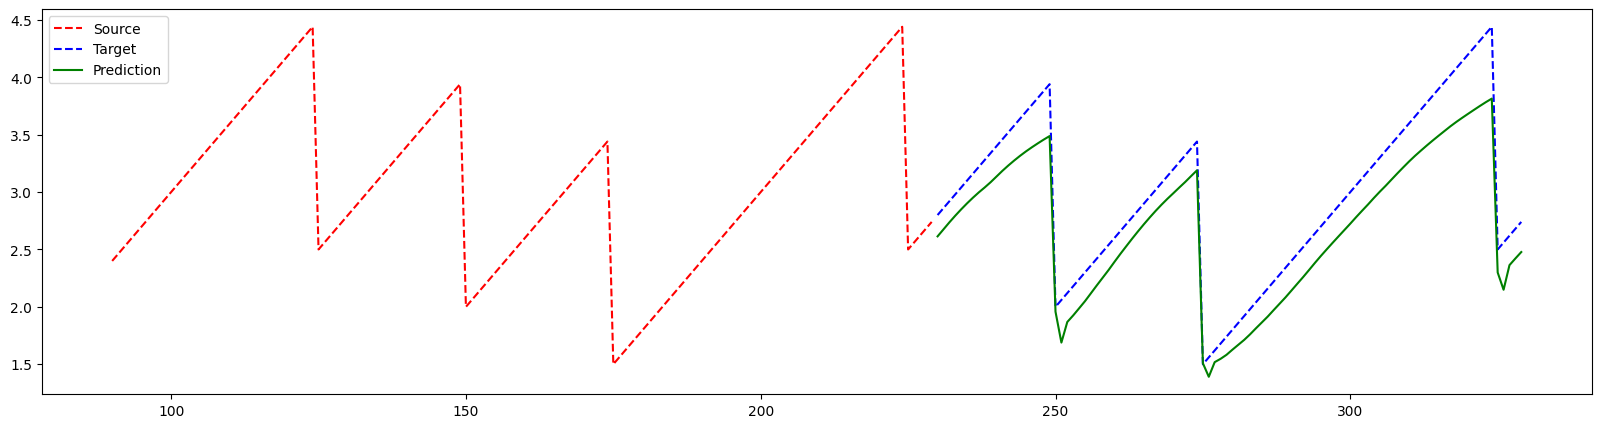

In [157]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [158]:
inspect_step = 0

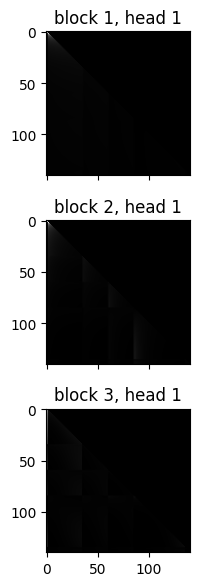

In [159]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

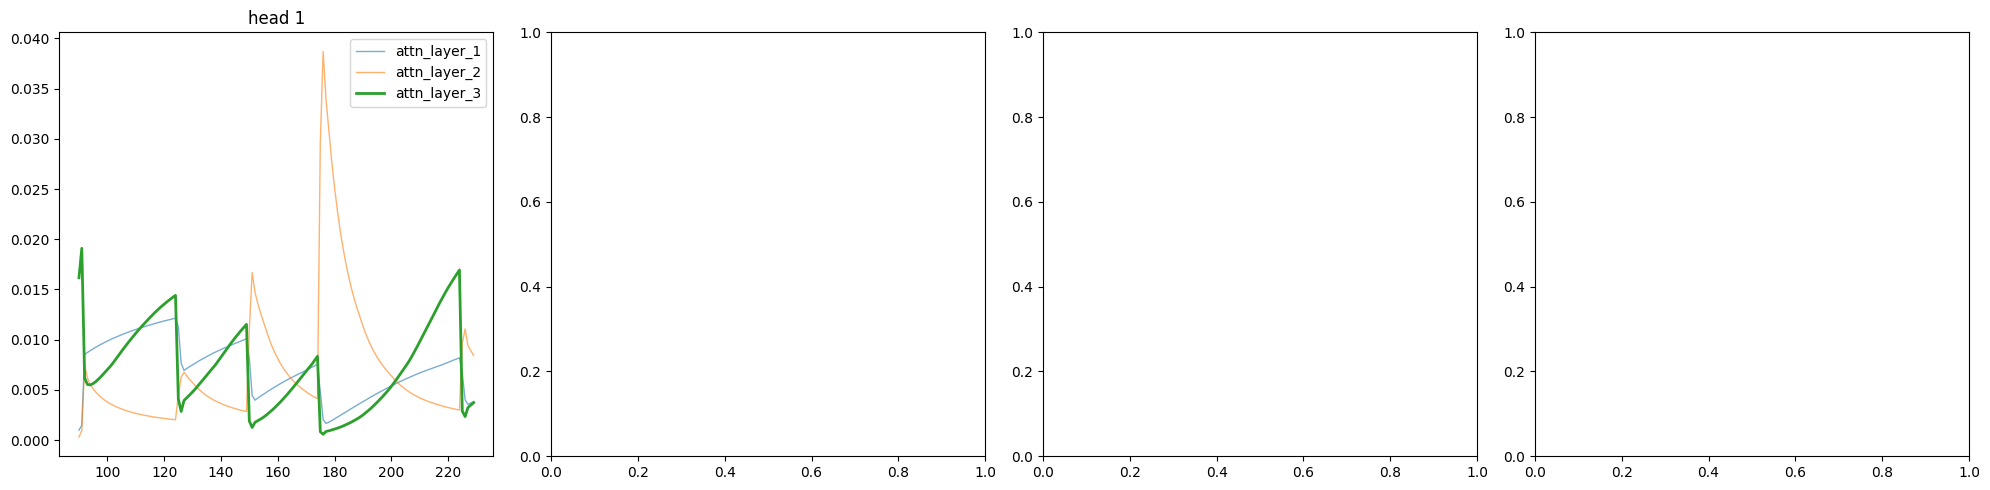

In [160]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

In [161]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)